In [29]:
import sys
print("Python:", sys.version)

import tensorflow as tf
print("TensorFlow:", tf.__version__)

import sklearn
print("scikit-learn:", sklearn.__version__)

import notebook
print("Jupyter Notebook:", notebook.__version__)


Python: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
TensorFlow: 2.18.0
scikit-learn: 1.5.1
Jupyter Notebook: 6.5.7


In [30]:
import plotly.io as pio
pio.renderers.default = "notebook"  # Use "notebook" for basic inline rendering

import os
os.environ["OMP_NUM_THREADS"] = "5"  # Set threads before importing any libraries

#  Defining CVAE Architecture


In [31]:
import tensorflow as tf
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from skimage.filters import gaussian
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error
from keras.models import load_model
import cv2
from PIL import Image
import os


def gaussian_blur(img, sigma):
    """Returns the Gaussian blurred version of the image 'img' with a sigma value of 'sigma'"""
    return np.array(gaussian(img, (sigma, sigma)))


def gaussian_blur_arr(images, sigma):
    """Applies the function gaussian_blur to all images in the set 'images'"""
    a = []
    for img in images:
        a.append(gaussian_blur(img, sigma))
    return np.array(a)


def norm_max_pixel(images):
    """Normalizes each image in the array 'images' such that the pixel intensities are within a range of 0 to 1"""
    a = []
    for img in images:
        img = img / np.max(img)
        a.append(img)
    return np.array(a)


def preprocess_images(images, size, sigma):
    """Preprocesses each image in the array 'images' applying the proper blurring, normalization, and shape to each image"""
    images = gaussian_blur_arr(images, sigma)
    images = norm_max_pixel(images)
    images = images.reshape((images.shape[0], size, size, 1))
    return images.astype('float32')


def get_predictions_from_model(model, images):
    """Returns an array of images 'prd' containing the prediction of each image in the input array 'images' from the CVAE model 'model'"""
    prd = []
    for i in range(len(images)):
        prd.append(model.predict(images[i:i + 1])[0, :, :, 0])
    return np.array(prd)


def get_difference(images, prd):
    """Returns an array of images containing the difference of each image in the input array 'images' with its respective prediction of the model in the input array 'prd'"""
    a = []
    for i in range(len(images)):
        d = images[i, :, :, 0] - prd[i]
        a.append(d)
    return np.array(a)


def get_heatmap(images):
    "Set all pixels with an absolute value lower than MAX_PIXEL to 0"
    return np.where(abs(images) < MAX_PIXEL, 0, images)


def get_avg_near_max(images):
    """Returns the average pixel intensity in an area of about a column size around the pixel with largest absolute value"""
    a = []
    for img in images:
        xmax, ymax = np.unravel_index(np.argmax(abs(img), axis=None), img.shape)
        s = 0
        c = 0
        for i in range(-CLMN_SIZE, CLMN_SIZE + 1):
            for j in range(-CLMN_SIZE, CLMN_SIZE + 1):
                try:
                    s += img[xmax + i][ymax + j]
                    c += 1
                except:
                    pass
        a.append(s / c)
    return np.array(a)


def plot_ANM(images, Labels=[], width=15, height=15, xmin=-0.4, xmax=0.4, legend_loc=(.5, .75), legend_size="xx-large", limit_coefficient=1.5):
    """Plots the histograms of given arrays and calculates percentage within 1.5*std of the bulk (last array given)"""
    fig = plt.figure(figsize=(width, height))
    if Labels == []:
        Labels = np.arange(len(images))
    maxL = np.max([len(i) for i in Labels])

    i = 0
    bmin = images[-1].mean() - limit_coefficient * images[-1].std()
    bmax = images[-1].mean() + limit_coefficient * images[-1].std()
    if images[-1].std() == 0:
        bmin = -0.1
        bmax = 0.1
    ymax = 1
    tot_prob_finding_defects = 0

    for img in images:
        p = np.logical_and(img > bmin, img < bmax).sum() / len(img)
        if i < len(images) - 1:
            p = 100 - 100 * p
        else:
            p = 100 * p
        label = Labels[i] + " Detected " + " " * (maxL - len(Labels[i])) + " : {:.1f}%".format(p, 1 - p)
        print(label)
        y, x = plt.hist(img.flatten(), 100, (xmin, xmax), label=label)[:2]
        if np.max(y) > ymax:
            ymax = np.max(y)
        if i < len(images) - 1:
            tot_prob_finding_defects += p
        i += 1

    legend = fig.legend(loc=legend_loc, fontsize=legend_size, edgecolor="white")
    plt.plot([bmin, bmin], [0, ymax], 'k--', linewidth=1)
    plt.plot([bmax, bmax], [0, ymax], 'k--', linewidth=1)
    print("Total Probability of finding a defect image = {:.3f}".format(tot_prob_finding_defects / len(images)))


## Specify the paths

In [32]:
SIZE = 64
CLMN_SIZE = 6
path = "Path to/ your/ working directory/"
SIGMA = 1
epochs = 3000
latent_dim = 20
MAX_PIXEL = 0.22 #Sets a threshold to remove pixel intensities below the specified value to get the filtered difference image. 
im = Image.open("Path to/ your/ working directory/DataSet_CdTe/interstitial_90.tif").convert("L")
print(np.array(im).shape)
bulk_images = np.array(im)[0:64, 0:64].reshape(1, 64, 64)
print(bulk_images.shape)

(64, 64)
(1, 64, 64)


# Dense Layers

In [33]:
@tf.keras.utils.register_keras_serializable(package='Custom', name='CVAE')
class CVAE(tf.keras.Model):
    """Deeper Convolutional Variational Autoencoder."""
 
    def __init__(self, latent_dim):
        reduced_size = int(SIZE / 8)  # Further reduction to allow for deeper layers
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Deeper encoder with more convolutional layers
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(SIZE, SIZE, 1)),
                tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
                tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
                tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
                #tf.keras.layers.Conv2D(256, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(latent_dim + latent_dim),  # Outputting both mean and log-variance for latent space
            ]
        )

        # Deeper decoder with more Conv2DTranspose layers
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=reduced_size * reduced_size * 64, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(reduced_size, reduced_size, 64)),
                #tf.keras.layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2DTranspose(1, kernel_size=3, strides=1, padding='same'),  # No activation to avoid smoothing
            ]
        )
    def sample(self, eps=None, apply_sigmoid=True):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=(self.latent_dim,))
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            return tf.sigmoid(logits)
        return logits

    def call(self, image):
        mean, logvar = self.encode(image)
        z = self.reparameterize(mean, logvar)
        return self.sample(z)

    @classmethod
    def from_config(cls, config):
        latent_dim = config.get('latent_dim', 20)  # Provide a default value if not present
        return cls(latent_dim)

    def get_config(self):
        config = super(CVAE, self).get_config()
        config.update({
            'latent_dim': self.latent_dim
        })
        return config


## Load trained CVAE model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Difference array statistics:
Mean bin midpoints: 0.14554858200601303
Histogram range center: 0.14554858207702637
Mean bin counts: 40.96
Maximum bin count: 298.0
Peak bin position: 0.034970725886523724

Input array statistics:
Mean bin midpoints: 0.6589608339965344
Histogram range center: 0.658960834145546
Mean bin counts: 40.96
Maximum bin count: 86.0
Peak bin position: 0.437285378575325

Prediction array statistics:
Mean bin midpoints: 0.6209352618455887
Histogram range center: 0.6209352612495422
Mean bin counts: 40.96
Maximum bin count: 89.0
Peak bin position: 0.456399068236351

Peak position comparisons:
Input - Prediction: -0.019113689661026
Input - Difference: 0.4023146526888013
Prediction - Difference: 0.4214283423498273

Integrated Intensities for Input Images:
Integrated Positive Intensity_Input: 2437.9092
Integrated Negative Intensity_Input: 0.0000

Integrated Intensities for Difference Images:
Integrated Positive Intensity_Diff: 174.8219

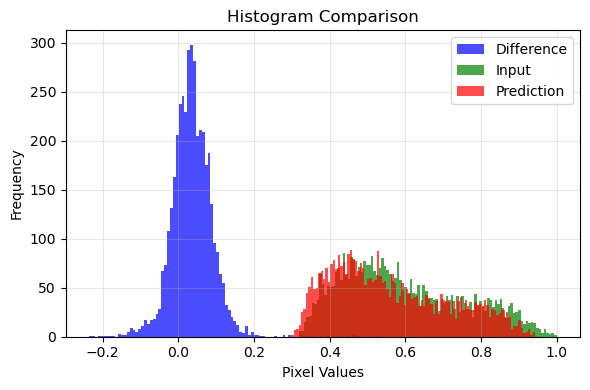

In [34]:
# Process input images
input_images = preprocess_images(bulk_images, SIZE, SIGMA)

# Uploading the trained CVAE model
set_name1 = "CdTe_Training_Image_L_Size64_Sigma1_epochs3000_latentdim20.keras"

model = load_model(
    path + set_name1.format(SIZE, SIGMA, epochs, latent_dim), 
    custom_objects={'CVAE': CVAE},
    compile=False
)

# Generate predictions and differences
predicted_images = get_predictions_from_model(model, input_images)
difference_images = get_difference(input_images, predicted_images)
difference_heatmap = get_heatmap(difference_images)

# Set transparency values for each histogram
alpha_diff = 0.7    # Transparency for difference histogram
alpha_bulk = 0.7    # Transparency for input histogram
alpha_prd = 0.7     # Transparency for prediction histogram

# Create a figure with a specific size
plt.figure(figsize=(6, 4))

# Difference array histogram statistics
bin_counts_diff, bin_edges_diff, _ = plt.hist(difference_images.flatten(), 100, 
                                             alpha=alpha_diff, 
                                             color='blue',
                                             label='Difference')
bin_midpoints_diff = (bin_edges_diff[:-1] + bin_edges_diff[1:]) / 2
histogram_range_center_diff = (bin_edges_diff[0] + bin_edges_diff[-1]) / 2
mean_bin_counts_diff = np.mean(bin_counts_diff)
max_bin_count_diff = np.max(bin_counts_diff)
mean_bin_midpoints_diff = np.mean(bin_midpoints_diff)
peak_bin_position_diff = bin_midpoints_diff[np.argmax(bin_counts_diff)]

# Input images histogram statistics
bin_counts_bulk, bin_edges_bulk, _ = plt.hist(input_images.flatten(), 100, 
                                             alpha=alpha_bulk, 
                                             color='green',
                                             label='Input')
bin_midpoints_bulk = (bin_edges_bulk[:-1] + bin_edges_bulk[1:]) / 2
histogram_range_center_bulk = (bin_edges_bulk[0] + bin_edges_bulk[-1]) / 2
mean_bin_counts_bulk = np.mean(bin_counts_bulk)
max_bin_count_bulk = np.max(bin_counts_bulk)
mean_bin_midpoints_bulk = np.mean(bin_midpoints_bulk)
peak_bin_position_bulk = bin_midpoints_bulk[np.argmax(bin_counts_bulk)]

# Prediction array histogram statistics
bin_counts_prd, bin_edges_prd, _ = plt.hist(predicted_images.flatten(), 100, 
                                           alpha=alpha_prd, 
                                           color='red',
                                           label='Prediction')
bin_midpoints_prd = (bin_edges_prd[:-1] + bin_edges_prd[1:]) / 2
histogram_range_center_prd = (bin_edges_prd[0] + bin_edges_prd[-1]) / 2
mean_bin_counts_prd = np.mean(bin_counts_prd)
max_bin_count_prd = np.max(bin_counts_prd)
mean_bin_midpoints_prd = np.mean(bin_midpoints_prd)
peak_bin_position_prd = bin_midpoints_prd[np.argmax(bin_counts_prd)]

# Peak position differences
peak_difference_bulk_prd = peak_bin_position_bulk - peak_bin_position_prd
peak_difference_bulk_diff = peak_bin_position_bulk - peak_bin_position_diff
peak_difference_prd_diff = peak_bin_position_prd - peak_bin_position_diff

# Compute integrated positive and negative intensities for the input original images
positive_integrals_input = np.sum(input_images[input_images > 0])
negative_integrals_input = np.sum(np.abs(input_images[input_images < 0]))

# Compute integrated positive and negative intensities for the difference images
positive_integrals_Diff = np.sum(difference_images[difference_images > 0])
negative_integrals_Diff = np.sum(np.abs(difference_images[difference_images < 0]))

# Compute integrated positive and negative intensities for the difference heatmap images
positive_integrals_heatmap = np.sum(difference_heatmap[difference_heatmap > 0])
negative_integrals_heatmap = np.sum(np.abs(difference_heatmap[difference_heatmap < 0]))



# Customize the plot
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.title('Histogram Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Print statistics
print("Difference array statistics:")
print(f"Mean bin midpoints: {mean_bin_midpoints_diff}")
print(f"Histogram range center: {histogram_range_center_diff}")
print(f"Mean bin counts: {mean_bin_counts_diff}")
print(f"Maximum bin count: {max_bin_count_diff}")
print(f"Peak bin position: {peak_bin_position_diff}")

print("\nInput array statistics:")
print(f"Mean bin midpoints: {mean_bin_midpoints_bulk}")
print(f"Histogram range center: {histogram_range_center_bulk}")
print(f"Mean bin counts: {mean_bin_counts_bulk}")
print(f"Maximum bin count: {max_bin_count_bulk}")
print(f"Peak bin position: {peak_bin_position_bulk}")

print("\nPrediction array statistics:")
print(f"Mean bin midpoints: {mean_bin_midpoints_prd}")
print(f"Histogram range center: {histogram_range_center_prd}")
print(f"Mean bin counts: {mean_bin_counts_prd}")
print(f"Maximum bin count: {max_bin_count_prd}")
print(f"Peak bin position: {peak_bin_position_prd}")

print("\nPeak position comparisons:")
print(f"Input - Prediction: {peak_difference_bulk_prd}")
print(f"Input - Difference: {peak_difference_bulk_diff}")
print(f"Prediction - Difference: {peak_difference_prd_diff}")

print("\nIntegrated Intensities for Input Images:")
print(f"Integrated Positive Intensity_Input: {positive_integrals_input:.4f}")
print(f"Integrated Negative Intensity_Input: {negative_integrals_input:.4f}")

print("\nIntegrated Intensities for Difference Images:")
print(f"Integrated Positive Intensity_Diff: {positive_integrals_Diff:.4f}")
print(f"Integrated Negative Intensity_Diff: {negative_integrals_Diff:.4f}")

print("\nIntegrated Intensities for Difference Heatmap Images:")
print(f"Integrated Positive Intensity_HM: {positive_integrals_heatmap:.4f}")
print(f"Integrated Negative Intensity_HM: {negative_integrals_heatmap:.4f}")

plt.tight_layout()
plt.show()

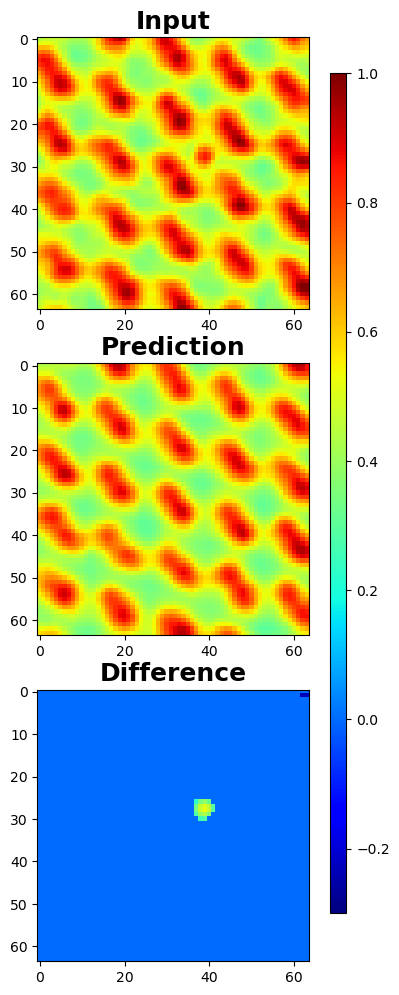

In [35]:
def plot_image_comparison(index=0, columns=1, rows=3, colormap='jet', fig_size=(4, 12), 
                         labels=["Input", "Prediction", "Difference"], title="Image Comparison"):
    
    # Create subplot grid
    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=fig_size, squeeze=False)
    
    # Get images using previously computed arrays and match dimensions
    input_slice = input_images[index:index+1, :, :, 0].squeeze()  # Remove extra dimensions
    predicted_slice = predicted_images[index]
    difference_slice = difference_heatmap[index]
    
    comparison_images = np.array([
        input_slice,
        predicted_slice,
        difference_slice
    ])
    
    # Validate input dimensions
    if len(comparison_images) < rows * columns:
        raise ValueError("Too many rows and columns for the available images")
    
    # Plot limits from previous analysis
    plot_min = -0.3
    plot_max = 1
    
    # Create subplots
    for row in range(rows):
        for col in range(columns):
            current_image = comparison_images[row * columns + col]
            image_plot = axes[row][col].imshow(
                current_image,
                vmin=plot_min,
                vmax=plot_max,
                cmap=colormap
            )
            axes[row][col].set_title(labels[row], fontsize=18, fontweight='bold')
    
    # Add colorbar
    fig.subplots_adjust(right=0.85)
    colorbar_axis = fig.add_axes([0.88, 0.15, 0.04, 0.7])
    fig.colorbar(image_plot, cax=colorbar_axis)

# Display the comparison
plot_image_comparison()

In [36]:
def load_and_preprocess_dataset(folder, target_size):
    """
    Loads and preprocesses images from a folder with proper resizing
    """
    dataset_images = []
    image_filenames = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith('.tif') or img_path.endswith('.jpg'):
            img = Image.open(img_path).convert('L')
            img = np.array(img)
            img = transform.resize(img, (target_size, target_size), 
                                mode='constant', anti_aliasing=True)
            dataset_images.append(img)
            image_filenames.append(filename)
    return np.array(dataset_images), image_filenames

def calculate_mean_squared_reconstruction_error(original_images, reconstructed_images):
    """
    Calculates pixel-wise mean squared error between original and reconstructed images
    """
    return np.mean((original_images - reconstructed_images) ** 2, axis=(1, 2, 3))

def compute_intensity_distribution(image):
    """
    Computes kernel density estimation for image intensity distribution
    """
    try:
        kernel_density = gaussian_kde(image.flatten())
        intensity_range = np.linspace(image.min(), image.max(), 1000)
        density_values = kernel_density.evaluate(intensity_range)
        return np.mean(density_values), intensity_range, density_values
    except Exception as e:
        print(f"Kernel density estimation failed: {e}")
        return None, None, None

def calculate_histogram_mean_position(data, num_bins=100):
    """
    Calculates mean position of histogram bins
    """
    counts, edges = np.histogram(data.flatten(), bins=num_bins)
    bin_centers = (edges[:-1] + edges[1:]) / 2
    return np.mean(bin_centers)

def calculate_histogram_peak_height(data, num_bins=100):
    """
    Calculates maximum height of histogram bins
    """
    counts, _ = np.histogram(data.flatten(), bins=num_bins)
    return np.max(counts)

def visualize_error_distribution(errors, density_distributions, plot_size=(16, 12)):
    """
    Creates visualization of reconstruction errors and intensity distributions
    """
    fig, ax = plt.subplots(1, 2, figsize=plot_size)
    
    # Error distribution plot
    ax[0].hist(errors, bins=50, alpha=0.75)
    ax[0].set_title('Reconstruction Error Distribution')
    ax[0].set_xlabel('Error Magnitude')
    ax[0].set_ylabel('Frequency')
    
    ax[1].set_title('Intensity Distribution Estimates')
    ax[1].set_xlabel('Pixel Intensity')
    ax[1].set_ylabel('Density')
    ax[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()

## Specify the path of input data folder  

In [37]:
# Load and process new dataset
dataset_folder = "Path to your input data folder/DataSet_CdTe/"

# Load and verify dataset
dataset_images, image_filenames = load_and_preprocess_dataset(dataset_folder, SIZE)
if dataset_images.size == 0:
    raise ValueError("Dataset loading failed. Please verify the folder path and image files.")

# Preprocess dataset
preprocessed_dataset = preprocess_images(dataset_images, SIZE, SIGMA)

# Generate predictions for dataset
dataset_predictions = get_predictions_from_model(model, preprocessed_dataset)
dataset_differences = get_difference(preprocessed_dataset, dataset_predictions)
dataset_heatmaps = get_heatmap(dataset_differences)

# Reshape predictions to match input format
dataset_predictions = dataset_predictions.reshape(dataset_predictions.shape[0], 
                                               dataset_predictions.shape[1], 
                                               dataset_predictions.shape[2], 1)

# Calculate reconstruction errors
reconstruction_errors = calculate_mean_squared_reconstruction_error(preprocessed_dataset, 
                                                                dataset_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

In [38]:
from tabulate import tabulate
from skimage.feature import local_binary_pattern
from skimage.measure import regionprops, label, shannon_entropy
from scipy.stats import skew, kurtosis
from scipy.fft import fft2
import numpy as np
from skimage import filters
from skimage.feature import canny, graycomatrix, graycoprops


# Initialize lists for data collection
data = []
features = []

# Process each image in the dataset
for filename, original_image, predicted_image, diff_image, error, heatmap in zip(
        image_filenames, 
        preprocessed_dataset, 
        dataset_predictions,
        dataset_differences, 
        reconstruction_errors, 
        dataset_heatmaps):
        
    # Ensure images are 2D grayscale
    original_image = np.squeeze(original_image)
    predicted_image = np.squeeze(predicted_image)
    diff_image = np.squeeze(diff_image)
    heatmap = np.squeeze(heatmap)

    # Ensure the images are 4D for reconstruction error calculation
    original_image_4d = np.expand_dims(original_image, axis=(0, -1))
    predicted_image_4d = np.expand_dims(predicted_image, axis=(0, -1))

    # Features from all cells
    # Reconstruction and histogram-based features
    reconstruction_error = calculate_mean_squared_reconstruction_error(original_image_4d, predicted_image_4d)
    mean_bin_midpoints_diff = calculate_histogram_mean_position(diff_image) 
    mean_bin_midpoints_input = calculate_histogram_mean_position(original_image)
    mean_bin_midpoints_pred = calculate_histogram_mean_position(predicted_image)
    mean_bin_midpoints_error = calculate_histogram_mean_position(error)
    max_bin_count_diff = calculate_histogram_peak_height(diff_image)
    
    avg_kde_input, _, _ = compute_intensity_distribution(original_image)
    avg_kde_pred, _, _ = compute_intensity_distribution(predicted_image)
    avg_kde_diff, _, _ = compute_intensity_distribution(diff_image)
    
    _, bin_edges_diff = np.histogram(diff_image.flatten(), 100)
    bin_midpoints_diff = (bin_edges_diff[:-1] + bin_edges_diff[1:]) / 2
    peak_bin_position_diff = bin_midpoints_diff[np.argmax(np.histogram(diff_image.flatten(), 100)[0])]
    
    _, bin_edges_input = np.histogram(original_image.flatten(), 100)
    bin_midpoints_input = (bin_edges_input[:-1] + bin_edges_input[1:]) / 2
    peak_bin_position_input = bin_midpoints_input[np.argmax(np.histogram(original_image.flatten(), 100)[0])]
    
    _, bin_edges_pred = np.histogram(predicted_image.flatten(), 100)
    bin_midpoints_pred = (bin_edges_pred[:-1] + bin_edges_pred[1:]) / 2
    peak_bin_position_pred = bin_midpoints_pred[np.argmax(np.histogram(predicted_image.flatten(), 100)[0])]
    
    _, bin_edges_fdif = np.histogram(heatmap.flatten(), 100)
    bin_midpoints_fdif = (bin_edges_fdif[:-1] + bin_edges_fdif[1:]) / 2
    peak_bin_position_fdif = bin_midpoints_fdif[np.argmax(np.histogram(heatmap.flatten(), 100)[0])]

    # Peak and mean differences
    peak_difference_input_pred = peak_bin_position_input - peak_bin_position_pred
    peak_difference_input_diff = peak_bin_position_input - peak_bin_position_diff
    peak_difference_input_fdif = peak_bin_position_input - peak_bin_position_fdif
    peak_difference_pred_diff = peak_bin_position_pred - peak_bin_position_diff
    peak_difference_pred_fdif = peak_bin_position_pred - peak_bin_position_fdif
    peak_difference_diff_fdif = peak_bin_position_diff - peak_bin_position_fdif

    mean_difference_input_pred = mean_bin_midpoints_input - mean_bin_midpoints_pred
    mean_difference_input_diff = mean_bin_midpoints_input - mean_bin_midpoints_diff
    mean_difference_pred_diff = mean_bin_midpoints_pred - mean_bin_midpoints_diff

    # Intensity statistics
    positive_integral_input = np.sum(original_image[original_image > 0])
    negative_integral_input = np.sum(np.abs(original_image[original_image < 0]))

    positive_integral_diff = np.sum(diff_image[diff_image > 0])
    negative_integral_diff = np.sum(np.abs(diff_image[diff_image < 0]))

    positive_integral_fdif = np.sum(heatmap[heatmap > 0])
    negative_integral_fdif = np.sum(np.abs(heatmap[heatmap < 0]))

    # Intensity-based features
    skewness_input = skew(original_image.flatten())
    kurtosis_input = kurtosis(original_image.flatten())
    std_intensity_input = np.std(original_image)

    skewness_diff = skew(diff_image.flatten())
    kurtosis_diff = kurtosis(diff_image.flatten())
    std_intensity_diff = np.std(diff_image)

    # Shape-based features
    labeled_input = label(original_image > np.mean(original_image))
    region_props_input = regionprops(labeled_input)
    largest_region_input = max([prop.area for prop in region_props_input]) if region_props_input else 0

    labeled_diff = label(diff_image > np.mean(diff_image))
    region_props_diff = regionprops(labeled_diff)
    largest_region_diff = max([prop.area for prop in region_props_diff]) if region_props_diff else 0

    # Frequency-domain features
    fft_input = np.abs(fft2(original_image))
    fft_diff = np.abs(fft2(diff_image))

    mean_fft_input = np.mean(fft_input)
    var_fft_input = np.var(fft_input)

    mean_fft_diff = np.mean(fft_diff)
    var_fft_diff = np.var(fft_diff)

    edge_count_input = np.sum(canny(original_image))
    edge_length_input = np.mean(np.sum(canny(original_image, sigma=2), axis=0))
    fft_input = np.abs(np.fft.fft2(original_image))
    freq_band_ratio_input = np.sum(fft_input[:10, :10]) / np.sum(fft_input)
    radial_symmetry_input = np.mean(np.abs(original_image - np.flip(original_image, axis=0)))

    edge_count_diff = np.sum(canny(diff_image))
    edge_length_diff = np.mean(np.sum(canny(diff_image, sigma=2), axis=0))
    fft_diff = np.abs(np.fft.fft2(diff_image))
    freq_band_ratio_diff = np.sum(fft_diff[:10, :10]) / np.sum(fft_diff)
    radial_symmetry_diff = np.mean(np.abs(diff_image - np.flip(diff_image, axis=0)))

    
    # Append data row
    data.append([
        filename, reconstruction_error[0],
        mean_bin_midpoints_input, mean_bin_midpoints_diff, mean_bin_midpoints_pred, mean_bin_midpoints_error,
        max_bin_count_diff, avg_kde_input, avg_kde_diff,
        peak_bin_position_input, peak_bin_position_diff, peak_bin_position_pred, peak_bin_position_fdif,
        peak_difference_input_pred, peak_difference_input_diff, peak_difference_input_fdif,
        peak_difference_pred_diff, peak_difference_pred_fdif, peak_difference_diff_fdif,
        mean_difference_input_pred, mean_difference_input_diff, mean_difference_pred_diff,
        positive_integral_input, negative_integral_input,
        positive_integral_diff, negative_integral_diff,
        positive_integral_fdif, negative_integral_fdif,
        skewness_input, kurtosis_input, std_intensity_input,
        skewness_diff, kurtosis_diff, std_intensity_diff,
        largest_region_input, largest_region_diff,
        mean_fft_input, var_fft_input, mean_fft_diff, var_fft_diff,
        edge_count_input, edge_length_input, 
        freq_band_ratio_input, radial_symmetry_input,
        edge_count_diff, edge_length_diff, 
        freq_band_ratio_diff, radial_symmetry_diff ])

    # Append features row (numerical values only)
    features.append([
        reconstruction_error[0],
        mean_bin_midpoints_input, mean_bin_midpoints_diff, mean_bin_midpoints_pred, mean_bin_midpoints_error,
        max_bin_count_diff, avg_kde_input, avg_kde_diff,
        peak_bin_position_input, peak_bin_position_diff, peak_bin_position_pred, peak_bin_position_fdif,
        peak_difference_input_pred, peak_difference_input_diff, peak_difference_input_fdif,
        peak_difference_pred_diff, peak_difference_pred_fdif, peak_difference_diff_fdif,
        mean_difference_input_pred, mean_difference_input_diff, mean_difference_pred_diff,
        positive_integral_input, negative_integral_input,
        positive_integral_diff, negative_integral_diff,
        positive_integral_fdif, negative_integral_fdif,
        skewness_input, kurtosis_input, std_intensity_input,
        skewness_diff, kurtosis_diff, std_intensity_diff,
        largest_region_input, largest_region_diff,
        mean_fft_input, var_fft_input, mean_fft_diff, var_fft_diff,
        edge_count_input, edge_length_input, 
        freq_band_ratio_input, radial_symmetry_input,
        edge_count_diff, edge_length_diff, 
        freq_band_ratio_diff, radial_symmetry_diff ])

# Define headers with updated names
headers = [
    "Image", "F1: Reconstruction Error", 
    "F2: Mean Bin Midpoints Input", "F3: Mean Bin Midpoints Diff", "F4: Mean Bin Midpoints Pred", "F5: Mean Bin Midpoints Error", 
    "F6: Max Bin Count Diff", "F7: Avg KDE Input", "F8: Avg KDE Diff",
    "F9: Peak Bin Position Input", "F10: Peak Bin Position Diff", "F11: Peak Bin Position Pred", "F12: Peak Bin Position Fdif",
    "F13: Peak Diff Input-Pred", "F14: Peak Diff Input-Diff", "F15: Peak Diff Input-Fdif", 
    "F16: Peak Diff Pred-Diff", "F17: Peak Diff Pred-Fdif", "F18: Peak Diff Diff-Fdif", 
    "F19: Mean Diff Input-Pred", "F20: Mean Diff Input-Diff", "F21: Mean Diff Pred-Diff",
    "F22: Pos Integral Input", "F23: Neg Integral Input", "F24: Pos Integral Diff", "F25: Neg Integral Diff", "F26: Pos Integral Fdif",
    "F27: Neg Integral Fdif", "F28: Skewness Input", "F29: Kurtosis Input", "F30: Std Intensity Input", "F31: Skewness Diff", "F32: Kurtosis Diff",
    "F33: Std Intensity Diff", "F34: Largest Region Input", "F35: Largest Region Diff", "F36: Mean FFT Input", "F37: Var FFT Input",
    "F38: Mean FFT Diff", "F39: Var FFT Diff",
    "F40: Edge Count Input", "F41: Edge Length Input", 
    "F42: Freq Band Ratio Input", "F43: Radial Symmetry Input",
    "F44: Edge Count Diff", "F45: Edge Length Diff", 
    "F46: Freq Band Ratio Diff", "F47: Radial Symmetry Diff"]

# Validate header and data consistency
if len(headers) != len(data[0]):
    raise ValueError(f"Header length ({len(headers)}) does not match data columns ({len(data[0])}).")

# Print table
#print(tabulate(data, headers=headers, floatfmt=".4f", tablefmt="grid"))
print(tabulate(data[:10], headers=headers, floatfmt=".4f", tablefmt="grid"))  # Display only first 10 rows


+--------------+----------------------------+--------------------------------+-------------------------------+-------------------------------+--------------------------------+--------------------------+---------------------+--------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-----------------------------+-----------------------------+-----------------------------+----------------------------+----------------------------+----------------------------+-----------------------------+-----------------------------+----------------------------+---------------------------+---------------------------+--------------------------+--------------------------+--------------------------+--------------------------+-----------------------+-----------------------+----------------------------+----------------------+----------------------+---------------------------+-----------------------------+----------------

# Feature Normalization

In [39]:
print(f"Original features shape before normalization: {np.array(features).shape}") 


Original features shape before normalization: (1119, 47)


In [40]:
import numpy as np

# Convert features to a NumPy array without dropping any columns
features_array = np.array(features, dtype=float)  # Keep all columns

# Debug: Print the shape to confirm correctness
print(f"✅ Features shape before normalization: {features_array.shape}")  

# Compute min and max values for each feature
min_vals = np.min(features_array, axis=0)
max_vals = np.max(features_array, axis=0)

# Compute feature range
feature_ranges = max_vals - min_vals
zero_range_features = feature_ranges == 0  # Identify constant features

# Initialize normalized array
features_normalized = np.zeros_like(features_array, dtype=float)

# Normalize each feature to the range [-1, 1], handling constant features
for i in range(features_array.shape[1]):
    if zero_range_features[i]:
        features_normalized[:, i] = 0  # Set constant features to 0
    else:
        features_normalized[:, i] = 2 * (features_array[:, i] - min_vals[i]) / feature_ranges[i] - 1

# Verify normalization
print("\n✅ Feature ranges after normalization:")
print("Min values:", np.min(features_normalized, axis=0))  # Should be ≥ -1
print("Max values:", np.max(features_normalized, axis=0))  # Should be ≤ 1

# Check final shape
print(f"✅ Final normalized features shape: {features_normalized.shape}")  

# # Ensure all values are within [-1, 1]
# within_range = np.all((features_normalized >= -1) & (features_normalized <= 1))
# print("\n✅ All values within [-1, 1] range:", within_range)


✅ Features shape before normalization: (1119, 47)

✅ Feature ranges after normalization:
Min values: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
Max values: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
✅ Final normalized features shape: (1119, 47)


# Saving Normalized features as a "csv" file for later use

In [93]:
import pandas as pd

# Define the filename for saving
output_filename = "Path to your working directory/normalized_features.csv"

# Convert the normalized features array to a DataFrame
normalized_features_df = pd.DataFrame(features_normalized, columns=headers[1:])  # Exclude 'Image' column

# Save the DataFrame to a CSV file
normalized_features_df.to_csv(output_filename, index=False)

#print(f"✅ Normalized features saved successfully as '{output_filename}'")


## Loading the "normalized_features.csv" file 

In [43]:
import pandas as pd
import numpy as np

# Step 1: Path to the saved CSV file
csv_file_path = "Path to your working directory/normalized_features.csv"

# Step 2: Load the CSV as a DataFrame
df = pd.read_csv(csv_file_path)

# Step 3: Convert to NumPy array (optional for modeling or plotting)
features_normalized = df.values

# Step 4: Print shape and data preview
print(f"✅ CSV file shape: {df.shape}")  # Rows × Columns
print("\n✅ First 5 rows:")
print(df.head())

✅ CSV file shape: (1119, 47)

✅ First 5 rows:
   F1: Reconstruction Error  F2: Mean Bin Midpoints Input  \
0                 -0.858077                      0.240059   
1                 -0.834547                      0.240059   
2                 -0.911527                      0.212142   
3                 -0.893108                      0.296078   
4                 -0.938424                      0.267258   

   F3: Mean Bin Midpoints Diff  F4: Mean Bin Midpoints Pred  \
0                    -0.209444                     0.238396   
1                     0.072382                     0.365617   
2                     0.110333                     0.318792   
3                     0.189630                     0.095708   
4                    -0.061735                     0.392089   

   F5: Mean Bin Midpoints Error  F6: Max Bin Count Diff  F7: Avg KDE Input  \
0                     -0.858077               -0.620072           0.040208   
1                     -0.834547               -0.498

In [44]:
# Define headers with updated names
headers = [
    "Image", "F1: Reconstruction Error", 
    "F2: Mean Bin Midpoints Input", "F3: Mean Bin Midpoints Diff", "F4: Mean Bin Midpoints Pred", "F5: Mean Bin Midpoints Error", 
    "F6: Max Bin Count Diff", "F7: Avg KDE Input", "F8: Avg KDE Diff",
    "F9: Peak Bin Position Input", "F10: Peak Bin Position Diff", "F11: Peak Bin Position Pred", "F12: Peak Bin Position Fdif",
    "F13: Peak Diff Input-Pred", "F14: Peak Diff Input-Diff", "F15: Peak Diff Input-Fdif", 
    "F16: Peak Diff Pred-Diff", "F17: Peak Diff Pred-Fdif", "F18: Peak Diff Diff-Fdif", 
    "F19: Mean Diff Input-Pred", "F20: Mean Diff Input-Diff", "F21: Mean Diff Pred-Diff",
    "F22: Pos Integral Input", "F23: Neg Integral Input", "F24: Pos Integral Diff", "F25: Neg Integral Diff", "F26: Pos Integral Fdif",
    "F27: Neg Integral Fdif", "F28: Skewness Input", "F29: Kurtosis Input", "F30: Std Intensity Input", "F31: Skewness Diff", "F32: Kurtosis Diff",
    "F33: Std Intensity Diff", "F34: Largest Region Input", "F35: Largest Region Diff", "F36: Mean FFT Input", "F37: Var FFT Input",
    "F38: Mean FFT Diff", "F39: Var FFT Diff",
    "F40: Edge Count Input", "F41: Edge Length Input", 
    "F42: Freq Band Ratio Input", "F43: Radial Symmetry Input",
    "F44: Edge Count Diff", "F45: Edge Length Diff", 
    "F46: Freq Band Ratio Diff", "F47: Radial Symmetry Diff"]

In [45]:
# Define headers for the features (assuming the first column was skipped for normalization)
feature_headers = headers[1:]  # Skip the first column (image names)

# Print the names of the normalized features
print("Normalized Feature Names:")
for i, name in enumerate(feature_headers):
    print(f"{i}: {name}")


Normalized Feature Names:
0: F1: Reconstruction Error
1: F2: Mean Bin Midpoints Input
2: F3: Mean Bin Midpoints Diff
3: F4: Mean Bin Midpoints Pred
4: F5: Mean Bin Midpoints Error
5: F6: Max Bin Count Diff
6: F7: Avg KDE Input
7: F8: Avg KDE Diff
8: F9: Peak Bin Position Input
9: F10: Peak Bin Position Diff
10: F11: Peak Bin Position Pred
11: F12: Peak Bin Position Fdif
12: F13: Peak Diff Input-Pred
13: F14: Peak Diff Input-Diff
14: F15: Peak Diff Input-Fdif
15: F16: Peak Diff Pred-Diff
16: F17: Peak Diff Pred-Fdif
17: F18: Peak Diff Diff-Fdif
18: F19: Mean Diff Input-Pred
19: F20: Mean Diff Input-Diff
20: F21: Mean Diff Pred-Diff
21: F22: Pos Integral Input
22: F23: Neg Integral Input
23: F24: Pos Integral Diff
24: F25: Neg Integral Diff
25: F26: Pos Integral Fdif
26: F27: Neg Integral Fdif
27: F28: Skewness Input
28: F29: Kurtosis Input
29: F30: Std Intensity Input
30: F31: Skewness Diff
31: F32: Kurtosis Diff
32: F33: Std Intensity Diff
33: F34: Largest Region Input
34: F35: Largest

In [46]:
print(f"features_normalized shape: {features_normalized.shape}") 
print(f"feature_headers length: {len(feature_headers)}")  
#both should be same

features_normalized shape: (1119, 47)
feature_headers length: 47


## Visualizing every feature and its range 

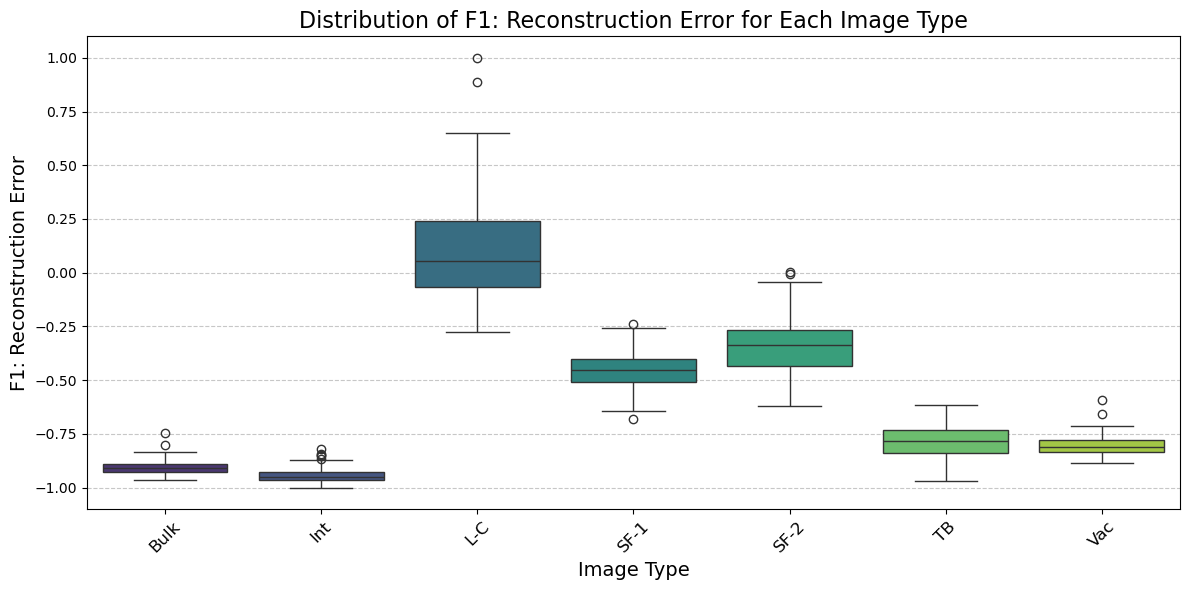

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Exclude the first column (Image) from headers to align with features
feature_headers = headers[1:]  # Skip "Image" column

# Ensure the length of feature_headers matches features_normalized
feature_headers = feature_headers[:features_normalized.shape[1]]

# Convert normalized features into a DataFrame with correctly aligned column names
df_features_normalized = pd.DataFrame(features_normalized, columns=feature_headers)

# Add filename column separately
df_features_normalized['Filename'] = image_filenames

# Add Image Type Information
df_features_normalized['Type'] = df_features_normalized['Filename'].apply(
    lambda x: 'Bulk' if x.startswith('Bulk') and not x.startswith('BulkDefect') 
    else 'L-C' if x.startswith('LC') 
    else 'Int' if x.startswith('interstitial') 
    else 'Vac' if x.startswith('Vacancy_CdTe')
    else 'SF-1' if x.startswith('SF1')
    else 'SF-2' if x.startswith('SF2')
    else 'TB' if x.startswith('Twin_Bound')
    else 'Other'
)

# Select the correct feature name
feature_index = 0  # Change dynamically to view other features
feature_name = feature_headers[feature_index]  # Now correctly aligned

# Plot the selected feature for all Image Types
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_features_normalized, x='Type', y=feature_name, hue='Type', palette='viridis', legend=False)
plt.title(f"Distribution of {feature_name} for Each Image Type", fontsize=16)
plt.xlabel("Image Type", fontsize=14)
plt.ylabel(feature_name, fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


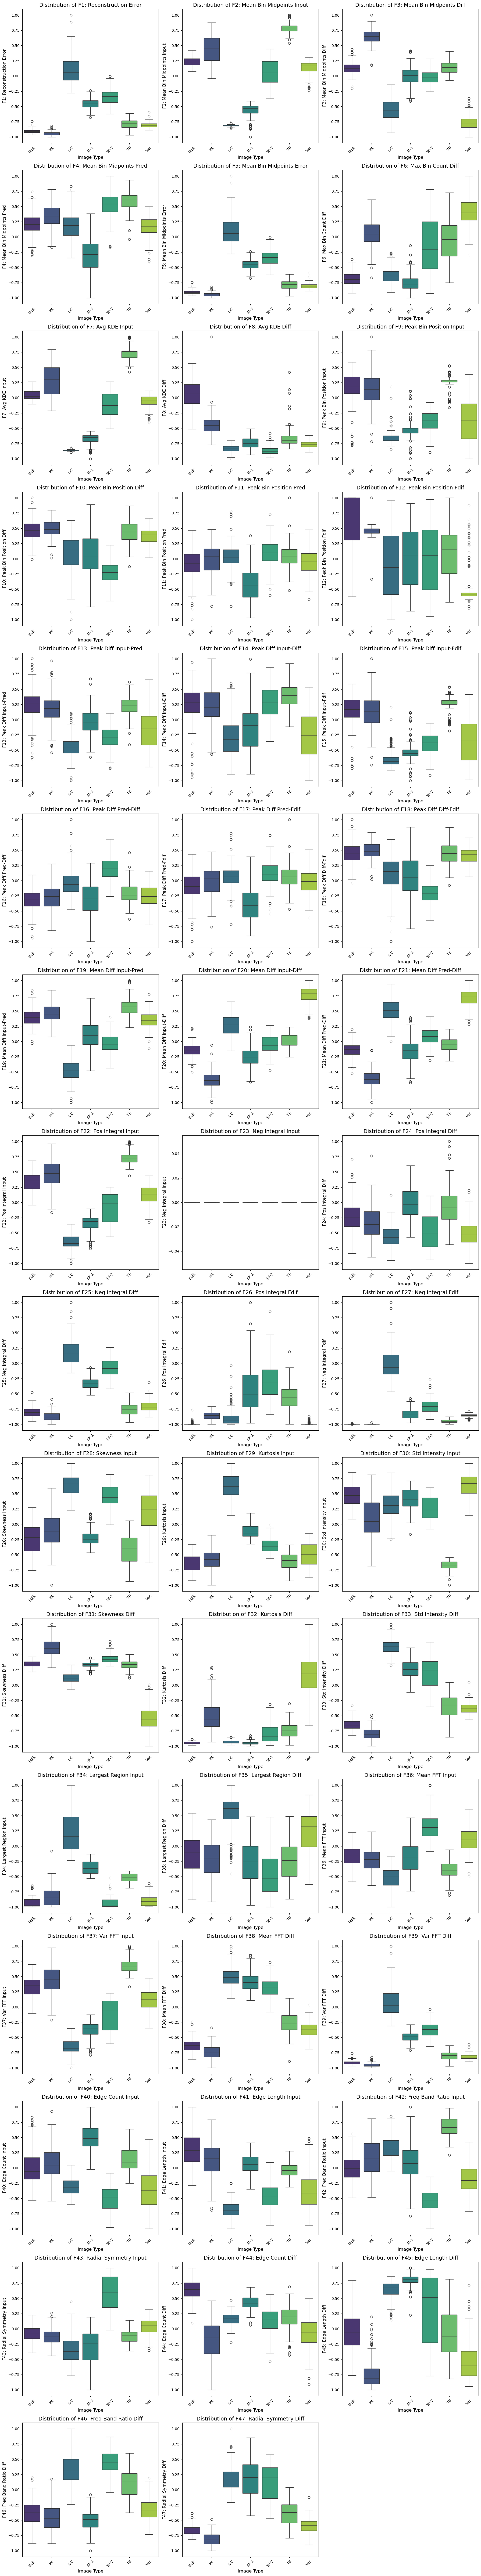

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Exclude the first column ("Image") and ensure alignment
feature_headers = headers[1:]  # Skip "Image" column

# Ensure feature_headers length matches features_normalized shape
feature_headers = feature_headers[:features_normalized.shape[1]]

# Verify the shape consistency
if features_normalized.shape[1] != len(feature_headers):
    raise ValueError(
        f"Mismatch in feature count: features_normalized has {features_normalized.shape[1]} features, "
        f"but headers imply {len(feature_headers)}."
    )

# Convert normalized features into a DataFrame
df_features_normalized = pd.DataFrame(features_normalized, columns=feature_headers)

# Add Filename and Image Type columns
df_features_normalized['Filename'] = image_filenames
df_features_normalized['Type'] = df_features_normalized['Filename'].apply(
    lambda x: 'Bulk' if x.startswith('Bulk') and not x.startswith('BulkDefect') 
    else 'L-C' if x.startswith('LC') 
    else 'Int' if x.startswith('interstitial') 
    else 'Vac' if x.startswith('Vacancy_CdTe')
    else 'SF-1' if x.startswith('SF1')
    else 'SF-2' if x.startswith('SF2')
    else 'TB' if x.startswith('Twin_Bound')
    else 'Other'
)
# Number of features
num_features = len(feature_headers)

# Set up the grid of subplots
num_cols = 3  # 3 columns per row
num_rows = -(-num_features // num_cols)  # Compute the number of rows (ceiling division)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 6), sharex=False)

# Flatten axes for easy iteration (handle cases where num_rows = 1)
axes = axes.flatten()

# Plot each feature
for i, feature_name in enumerate(feature_headers):
    sns.boxplot(
    data=df_features_normalized, 
    x='Type', 
    y=feature_name, 
    hue='Type',  # Explicitly assign hue
    palette='viridis', 
    legend=False,  # Hide redundant legend
    ax=axes[i]
    )

    axes[i].set_title(f"Distribution of {feature_name}", fontsize=14)
    axes[i].set_xlabel("Image Type", fontsize=12)
    axes[i].set_ylabel(feature_name, fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Box plot panels

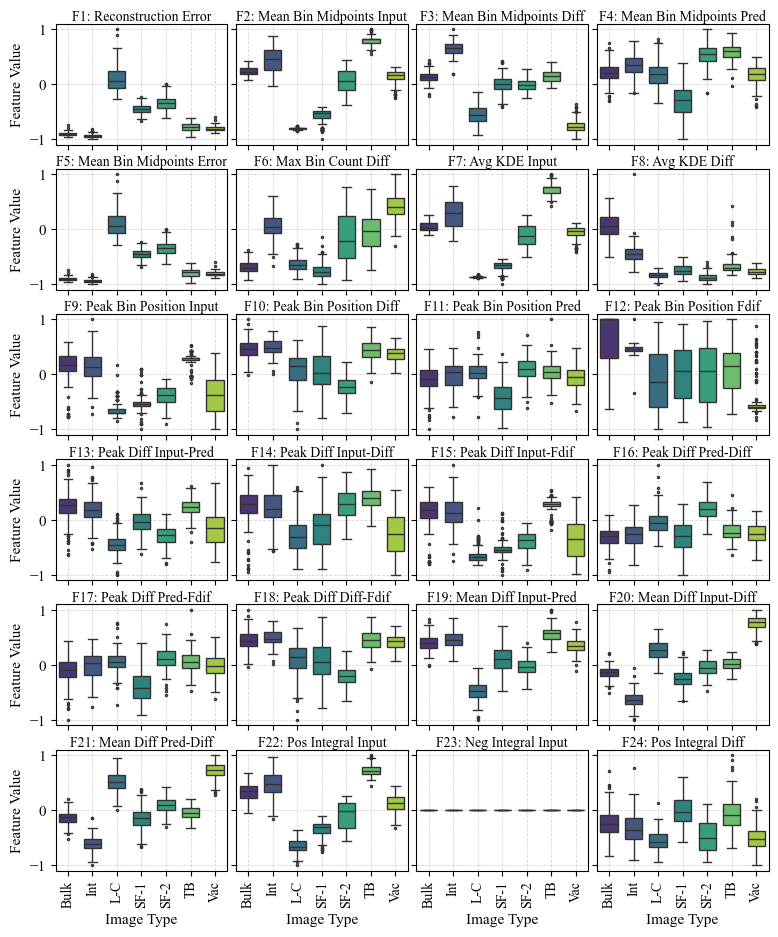

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set font globally to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Define subplot grid (6 rows × 4 columns) for a total of 24 subplots
num_rows, num_cols = 6, 4  
figsize = (9.2, 11)  # Final page size after margins

# Define feature selection (update these values as needed)
start_feature = 0   # First feature index to plot
end_feature = 23    # Last feature index to plot
selected_features = feature_headers[start_feature:end_feature + 1]  # Slice selected features

# Gridline transparency control (adjust alpha as needed)
grid_alpha = 0.5  

# Define subplot spacing control
wspace = 0.05  # Horizontal space between plots
hspace = 0.2  # **Increased slightly for better spacing of feature names**

# Create the figure with shared x-axis and y-axis
fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Get unique image types for x-axis labels
image_types = df_features_normalized['Type'].unique()

# Plot each selected feature
for i, feature_name in enumerate(selected_features):
    sns.boxplot(
        data=df_features_normalized, 
        x='Type', 
        y=feature_name, 
        hue='Type',  
        palette='viridis', 
        legend=False,  
        width=0.7,  # **Make boxes thinner**
        flierprops={"markersize": 1.5},  # **Reduce outlier size**
        ax=axes[i]
    )

    # **Feature name centered at the top in black**
    axes[i].set_title(feature_name, fontsize=10, color='black', fontweight='normal', pad=1)

    # Add gridlines with transparency
    axes[i].grid(True, linestyle="--", linewidth=0.6, alpha=grid_alpha)

    # Remove individual x and y labels (shared axes will be set later)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# **Set shared y-axis labels and ticks on the leftmost column**
for i in range(0, len(selected_features), num_cols):  
    axes[i].set_ylabel("Feature Value", fontsize=11)
    axes[i].tick_params(axis='y', labelsize=11)

# **Set shared x-axis labels on the bottom row correctly**
for ax in axes[-num_cols:]:  
    ax.set_xlabel("Image Type", fontsize=11)
    ax.set_xticks(range(len(image_types)))
    ax.set_xticklabels(image_types, fontsize=10)  # Set tick labels first

    # Apply rotation **only** to tick labels (fixes rotation error)
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# **Remove any unused subplots**
for j in range(len(selected_features), len(axes)):
    fig.delaxes(axes[j])  # Remove extra empty plots

# Adjust layout for better spacing with custom `wspace` and `hspace`
plt.subplots_adjust(wspace=wspace, hspace=hspace)

# save_path = "Your Path/feature_distribution_panel_1.png"
# plt.savefig(save_path, dpi=600, bbox_inches="tight", pad_inches=0.03)

# Show the figure
plt.show()

#print(f"✅ Figure saved as: {save_path}")


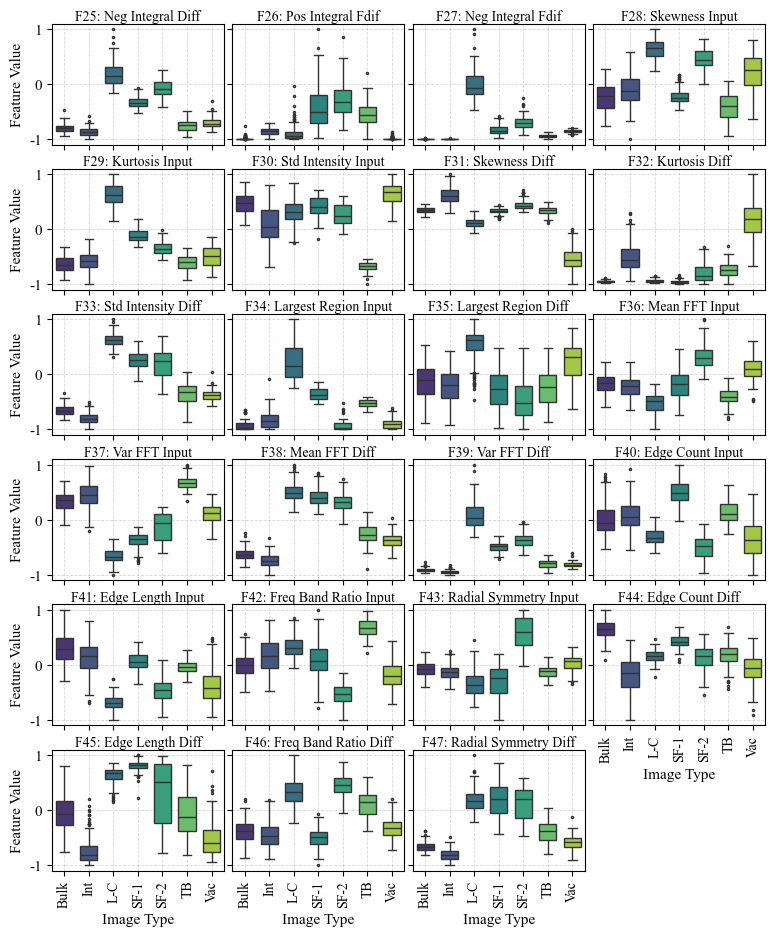

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set font globally to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Define subplot grid (6 rows × 4 columns) for a total of 24 subplots
num_rows, num_cols = 6, 4  
figsize = (9.2, 11)  # Final page size after margins

# Define feature selection
start_feature = 24   # First feature index to plot
end_feature = 46    # Last feature index to plot
selected_features = feature_headers[start_feature:end_feature + 1]  # Slice selected features

# Ensure we have exactly 24 plots by appending a placeholder feature if needed
if len(selected_features) < num_rows * num_cols:
    selected_features.append(None)  # Placeholder for the empty plot

# Gridline transparency control
grid_alpha = 0.5  

# Define subplot spacing control
wspace = 0.05  # Horizontal space between plots
hspace = 0.2   # Increased slightly for better spacing of feature names

# Create the figure with shared x-axis and y-axis
fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Get unique image types for x-axis labels
image_types = df_features_normalized['Type'].unique()

# Plot each selected feature
for i, feature_name in enumerate(selected_features):
    if feature_name is not None:
        sns.boxplot(
            data=df_features_normalized, 
            x='Type', 
            y=feature_name, 
            hue='Type',  
            palette='viridis', 
            legend=False,  
            width=0.7,  # Make boxes thinner
            flierprops={"markersize": 1.5},  # Reduce outlier size
            ax=axes[i]
        )

        # Feature name centered at the top in black
        axes[i].set_title(feature_name, fontsize=10, color='black', fontweight='normal', pad=1)

        # Add gridlines with transparency
        axes[i].grid(True, linestyle="--", linewidth=0.6, alpha=grid_alpha)

        # Remove individual x and y labels (shared axes will be set later)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")
    else:
        # **Make the last subplot completely empty and disable it from affecting shared axes**
        axes[i].axis("off")
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# **Force shared y-axis tick labels (-1, 0, 1) on the leftmost subplots**
for row in range(num_rows):
    leftmost_subplot = axes[row * num_cols]  # First subplot in each row
    leftmost_subplot.tick_params(axis='y', labelleft=True, labelsize=11)  # Ensure left ticks are visible
    leftmost_subplot.set_ylabel("Feature Value", fontsize=11)
    
    # **Set specific y-ticks to -1, 0, and 1**
    leftmost_subplot.set_yticks([-1, 0, 1])  
    leftmost_subplot.set_yticklabels(["-1", "0", "1"], fontsize=11)

# Ensure all subplots in the last row have rotated x-axis labels
for ax in axes[-num_cols:]:  
    ax.set_xlabel("Image Type", fontsize=11)
    ax.set_xticks(range(len(image_types)))
    ax.set_xticklabels(image_types, fontsize=10)  

    # Rotate tick labels for readability
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# **Manually force the x-axis labels and ticks on row 5, col 4 subplot**
last_used_ax = axes[-num_cols - 1]  # This corresponds to row 5, col 4
last_used_ax.set_xlabel("Image Type", fontsize=11)  # **FORCE THE X-AXIS LABEL**
last_used_ax.xaxis.label.set_visible(True)  # **Ensure the label is visible**

# Manually set the ticks
last_used_ax.set_xticks(range(len(image_types)))
last_used_ax.set_xticklabels(image_types, fontsize=10, rotation=90)

# **Ensure x-axis tick visibility explicitly**
last_used_ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

# **Disable last subplot completely so it doesn’t interfere**
axes[-1].axis("off")  # This ensures it does not affect shared axes

# Adjust layout for better spacing with custom `wspace` and `hspace`
plt.subplots_adjust(wspace=wspace, hspace=hspace)

# save_path = "Your Path/feature_distribution_panel_2.png"
# plt.savefig(save_path, dpi=600, bbox_inches="tight", pad_inches=0.03)

# Show the figure
plt.show()

#print(f"✅ Figure saved as: {save_path}")


# Using all 47 features for clustering

In [53]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

def optimize_pca_and_kmeans(normalized_features, max_pca_dims=20, max_clusters=12, variance_threshold=0.9):
    best_score = -1
    best_pca_dims = None
    best_num_clusters = None
    best_kmeans = None
    
    # Iterate over possible PCA dimensions
    for pca_dims in range(2, max_pca_dims + 1):
        # Apply PCA
        pca = PCA(n_components=pca_dims)
        pca_features = pca.fit_transform(normalized_features)
        
        # Check cumulative explained variance
        explained_variance = np.sum(pca.explained_variance_ratio_)
        if explained_variance < variance_threshold:
            continue
        
        # Iterate over possible cluster counts
        for num_clusters in range(2, max_clusters + 1):
            kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(pca_features)
            
            # Evaluate clustering performance using silhouette score
            score = silhouette_score(pca_features, cluster_labels)
            
            # Track the best configuration
            if score > best_score:
                best_score = score
                best_pca_dims = pca_dims
                best_num_clusters = num_clusters
                best_kmeans = kmeans
    
    return best_pca_dims, best_num_clusters, best_kmeans, best_score

In [54]:
# Run optimization
max_pca_dims = 20  # Maximum PCA dimensions to try
max_clusters = 12  # Maximum number of clusters to try
variance_threshold = 0.9  # Minimum variance explained by PCA

In [55]:
best_pca_dims, best_num_clusters, best_kmeans, best_score = optimize_pca_and_kmeans(
    features_normalized,  # Shortlisted features
    max_pca_dims=max_pca_dims, 
    max_clusters=max_clusters, 
    variance_threshold=variance_threshold
)

print(f"Optimal number of PCA dimensions: {best_pca_dims}")
print(f"Optimal number of clusters: {best_num_clusters}")
print(f"Best silhouette score: {best_score:.4f}")

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

Optimal number of PCA dimensions: 8
Optimal number of clusters: 5
Best silhouette score: 0.4860


C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

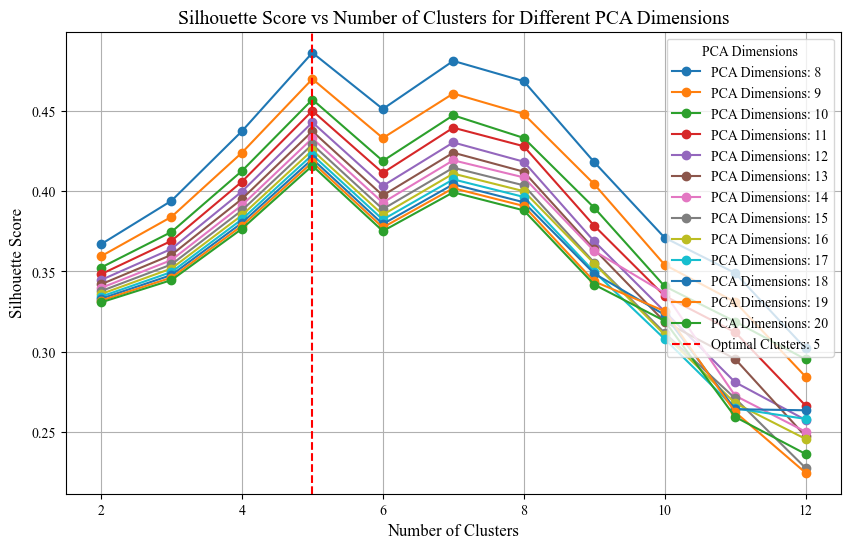

In [56]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Collect scores for plotting
cluster_range = range(2, max_clusters + 1)
pca_range = range(2, max_pca_dims + 1)
results = []

# Iterate over PCA dimensions and cluster counts to compute silhouette scores
for pca_dims in pca_range:
    pca = PCA(n_components=pca_dims)
    pca_features = pca.fit_transform(features_normalized)

    explained_variance = np.sum(pca.explained_variance_ratio_)
    if explained_variance < variance_threshold:
        continue

    pca_scores = []
    for num_clusters in cluster_range:
        #kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(pca_features)
        score = silhouette_score(pca_features, cluster_labels)
        pca_scores.append(score)

    results.append((pca_dims, pca_scores))

# Plot silhouette scores
plt.figure(figsize=(10, 6))
for pca_dims, scores in results:
    plt.plot(cluster_range, scores, marker='o', label=f'PCA Dimensions: {pca_dims}')

plt.axvline(x=best_num_clusters, color='r', linestyle='--', label=f'Optimal Clusters: {best_num_clusters}')
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score vs Number of Clusters for Different PCA Dimensions', fontsize=14)
plt.legend(title='PCA Dimensions', fontsize=10)
plt.grid()
plt.show()

In [57]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd

# Use the optimal number of PCA dimensions and clusters obtained earlier
pca = PCA(n_components=best_pca_dims)
pca_features_optimized = pca.fit_transform(features_normalized)
pca_columns = [f'PCA_{i+1}' for i in range(best_pca_dims)]

# Create a DataFrame for PCA-transformed features
df_features = pd.DataFrame(pca_features_optimized, columns=pca_columns)
df_features['Cluster'] = best_kmeans.labels_
df_features['Filename'] = image_filenames

# Add Image Type Information
df_features['Type'] = df_features['Filename'].apply(
    lambda x: 'Bulk' if x.startswith('Bulk') and not x.startswith('BulkDefect') 
    else 'L-C' if x.startswith('LC') 
    else 'Int' if x.startswith('interstitial') 
    else 'Vac' if x.startswith('Vacancy_CdTe')
    else 'SF-1' if x.startswith('SF1')
    else 'SF-2' if x.startswith('SF2')
    else 'TB' if x.startswith('Twin_Bound')
    #else 'Other'
    else None
)

# Define Markers and Colors 
markers = {
    'Bulk': 'o', 'L-C': 'v', 'Int': 'd', 'Vac': 's', 
    'SF-1': '*', 'SF-2': 'p', 'TB': '^'
}

colors = {
    'Bulk': 'r', 'L-C': 'g', 'Int': 'b', 'Vac': 'c', 
    'SF-1': 'brown', 'SF-2': 'm', 'TB': 'y'
}


In [58]:
# Initialize variables for accuracy tracking
cluster_accuracies = []

print("\nCluster Accuracy Details:\n")

# Loop through each cluster to calculate accuracy and list filenames
for cluster in range(best_num_clusters):
    # Filter data for the current cluster
    cluster_df = df_features[df_features['Cluster'] == cluster]

    if len(cluster_df) == 0:
        print(f"Cluster {cluster} is empty.\n")
        cluster_accuracies.append(0)
        continue

    # Find the most frequent image type in the cluster
    most_frequent_type = cluster_df['Type'].mode()[0]
    most_frequent_type_count = cluster_df['Type'].value_counts().get(most_frequent_type, 0)

    # Calculate accuracy for the cluster
    cluster_accuracy = (most_frequent_type_count / len(cluster_df)) * 100
    cluster_accuracies.append(cluster_accuracy)

    # Print details of the cluster
    print(f"Cluster {cluster}:")
    print(f"Image Names: {', '.join(cluster_df['Filename'].values)}")
    print(f"Image Type Counts:\n{cluster_df['Type'].value_counts()}")
    print(f"Most Frequent Type: {most_frequent_type}")
    print(f"Accuracy of Cluster {cluster}: {cluster_accuracy:.2f}%\n")

# Calculate overall accuracy
overall_accuracy = np.mean(cluster_accuracies)
print(f"Overall Clustering Accuracy: {overall_accuracy:.2f}%\n")



Cluster Accuracy Details:

Cluster 0:
Image Names: Bulk_0.tif, Bulk_1.tif, Bulk_10.tif, Bulk_100.tif, Bulk_101.tif, Bulk_102.tif, Bulk_103.tif, Bulk_104.tif, Bulk_105.tif, Bulk_106.tif, Bulk_107.tif, Bulk_108.tif, Bulk_109.tif, Bulk_11.tif, Bulk_110.tif, Bulk_111.tif, Bulk_112.tif, Bulk_113.tif, Bulk_114.tif, Bulk_115.tif, Bulk_116.tif, Bulk_117.tif, Bulk_118.tif, Bulk_119.tif, Bulk_12.tif, Bulk_120.tif, Bulk_121.tif, Bulk_122.tif, Bulk_123.tif, Bulk_124.tif, Bulk_125.tif, Bulk_126.tif, Bulk_127.tif, Bulk_128.tif, Bulk_129.tif, Bulk_13.tif, Bulk_130.tif, Bulk_131.tif, Bulk_132.tif, Bulk_133.tif, Bulk_134.tif, Bulk_135.tif, Bulk_136.tif, Bulk_137.tif, Bulk_138.tif, Bulk_139.tif, Bulk_14.tif, Bulk_140.tif, Bulk_141.tif, Bulk_142.tif, Bulk_143.tif, Bulk_144.tif, Bulk_145.tif, Bulk_146.tif, Bulk_147.tif, Bulk_148.tif, Bulk_149.tif, Bulk_15.tif, Bulk_150.tif, Bulk_151.tif, Bulk_152.tif, Bulk_153.tif, Bulk_154.tif, Bulk_155.tif, Bulk_156.tif, Bulk_157.tif, Bulk_158.tif, Bulk_159.tif, Bulk_1

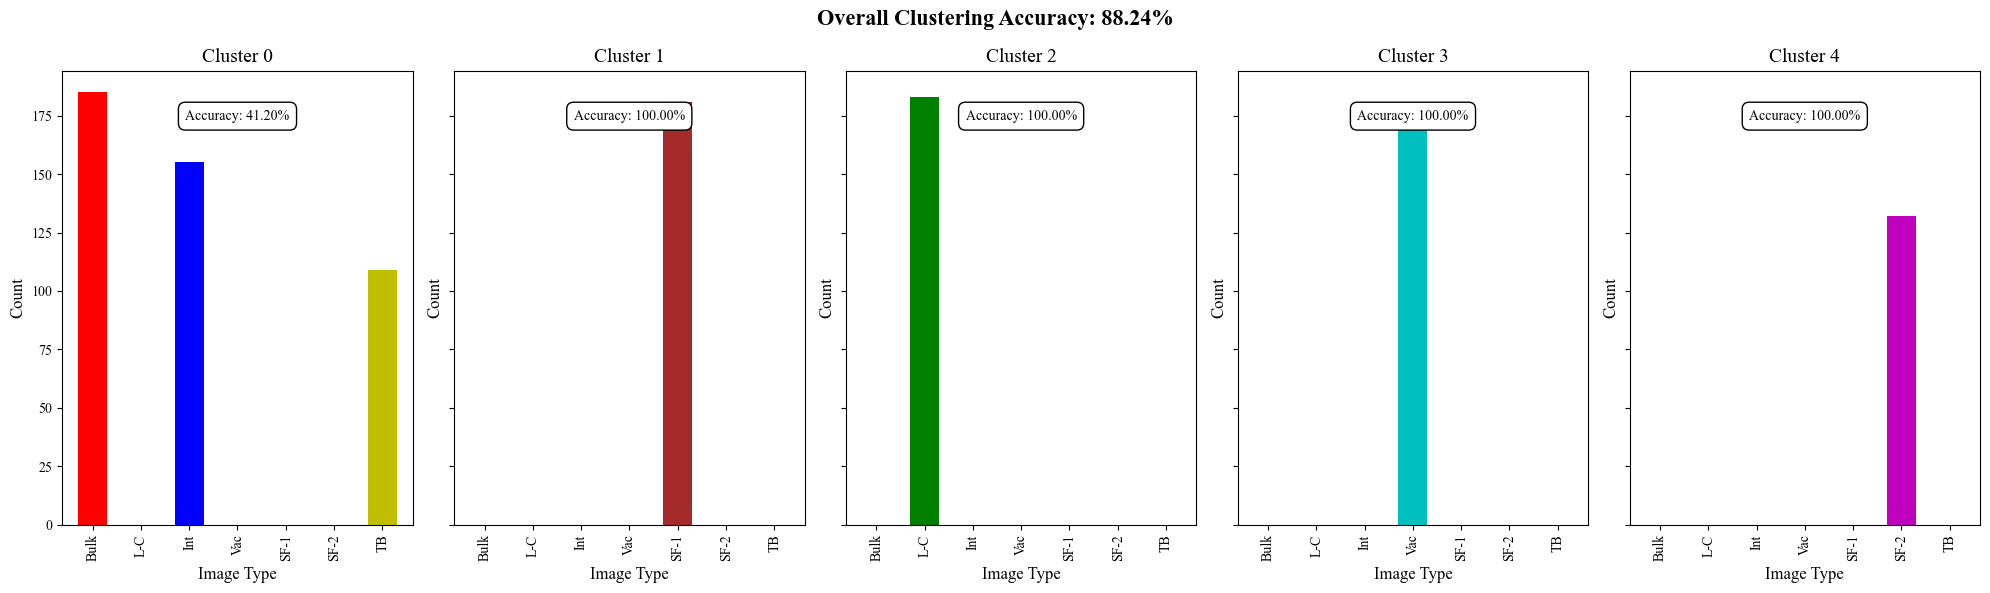

In [59]:
import matplotlib.pyplot as plt

# Create subplots for histograms of each cluster
fig, axes = plt.subplots(1, best_num_clusters, figsize=(20, 6), sharey=True)

for cluster in range(best_num_clusters):
    # Filter data for the current cluster
    cluster_df = df_features[df_features['Cluster'] == cluster]

    # Skip empty clusters
    if len(cluster_df) == 0:
        continue

    # Ensure all image types are present in the histogram, even if count is zero
    type_counts = cluster_df['Type'].value_counts().reindex(markers.keys(), fill_value=0)

    # Plot the histogram for the current cluster
    ax = axes[cluster]
    bars = ax.bar(
        type_counts.index, 
        type_counts.values, 
        color=[colors[t] for t in type_counts.index], 
        width=0.6
    )

    # Set title and labels for the current subplot
    ax.set_title(f"Cluster {cluster}", fontsize=14)
    ax.set_xlabel('Image Type', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x', rotation=90, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    # Add accuracy text for the cluster
    cluster_accuracy = cluster_accuracies[cluster]
    ax.text(
        0.5, 0.9, 
        f"Accuracy: {cluster_accuracy:.2f}%", 
        ha='center', va='center', transform=ax.transAxes, fontsize=10, 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
    )

# Add overall accuracy text as a figure title
plt.suptitle(f"Overall Clustering Accuracy: {overall_accuracy:.2f}%", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


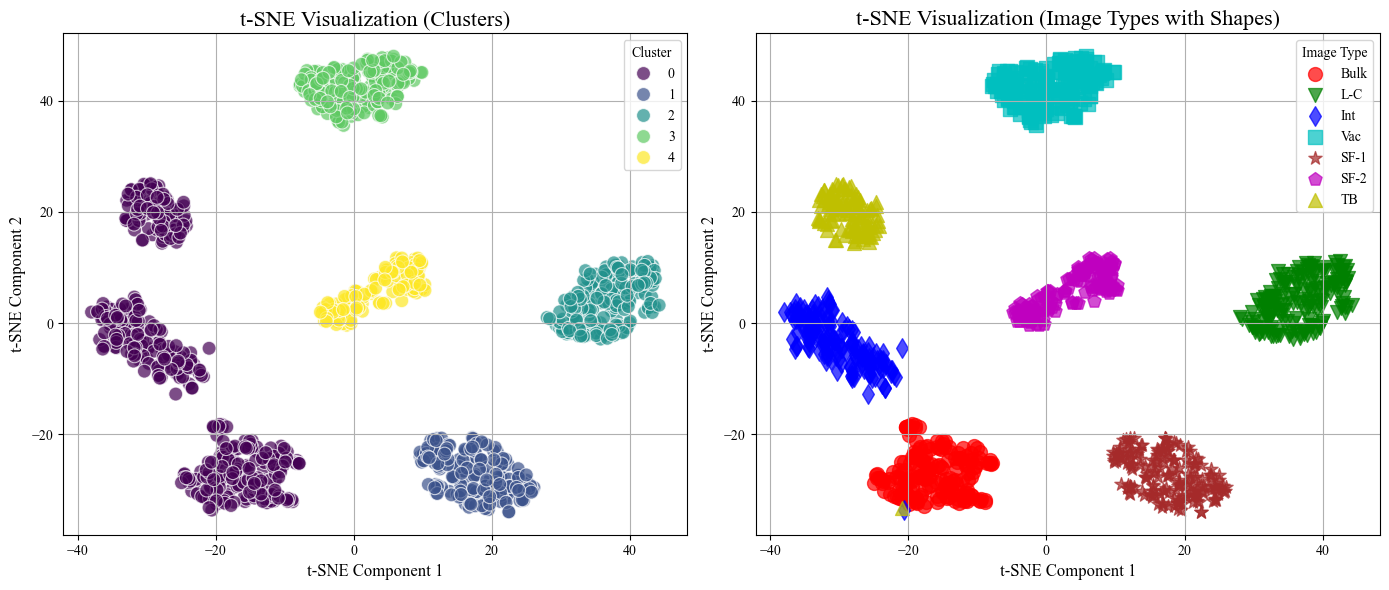

In [60]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Apply t-SNE to reduce the optimal PCA features to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(pca_features_optimized)

# Add t-SNE components to the DataFrame for easier access
df_features['t-SNE1'] = tsne_features[:, 0]
df_features['t-SNE2'] = tsne_features[:, 1]

# Create the figure
plt.figure(figsize=(14, 6))

# Plot 1: Clusters (Color-Coded by Cluster)
plt.subplot(1, 2, 1)
sns.scatterplot(
    x='t-SNE1', 
    y='t-SNE2', 
    hue='Cluster', 
    data=df_features, 
    palette='viridis', 
    s=100,  # Point size
    alpha=0.7
)
plt.title("t-SNE Visualization (Clusters)", fontsize=16)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(title="Cluster", fontsize=10)
plt.grid()

# Plot 2: Image Types (Legends with Shapes and Colors)
plt.subplot(1, 2, 2)
for img_type in markers:
    subset = df_features[df_features['Type'] == img_type]
    plt.scatter(
        subset['t-SNE1'], 
        subset['t-SNE2'], 
        marker=markers[img_type],  # Shape based on image type
        color=colors[img_type],   # Color based on image type
        label=img_type,
        alpha=0.7,
        s=100  # Point size
    )
plt.title("t-SNE Visualization (Image Types with Shapes)", fontsize=16)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(title="Image Type", fontsize=10)
plt.grid()

# Adjust layout
plt.tight_layout()
plt.show()


# Features Shortlisting: Correlation Analysis 

In [61]:
# Define headers for the features (assuming the first column was skipped for normalization)
feature_headers = headers[1:]  # Skip the first column (image names)

# Print the names of the normalized features
print("Normalized Feature Names:")
for i, name in enumerate(feature_headers):
    print(f"{i}: {name}")


Normalized Feature Names:
0: F1: Reconstruction Error
1: F2: Mean Bin Midpoints Input
2: F3: Mean Bin Midpoints Diff
3: F4: Mean Bin Midpoints Pred
4: F5: Mean Bin Midpoints Error
5: F6: Max Bin Count Diff
6: F7: Avg KDE Input
7: F8: Avg KDE Diff
8: F9: Peak Bin Position Input
9: F10: Peak Bin Position Diff
10: F11: Peak Bin Position Pred
11: F12: Peak Bin Position Fdif
12: F13: Peak Diff Input-Pred
13: F14: Peak Diff Input-Diff
14: F15: Peak Diff Input-Fdif
15: F16: Peak Diff Pred-Diff
16: F17: Peak Diff Pred-Fdif
17: F18: Peak Diff Diff-Fdif
18: F19: Mean Diff Input-Pred
19: F20: Mean Diff Input-Diff
20: F21: Mean Diff Pred-Diff
21: F22: Pos Integral Input
22: F23: Neg Integral Input
23: F24: Pos Integral Diff
24: F25: Neg Integral Diff
25: F26: Pos Integral Fdif
26: F27: Neg Integral Fdif
27: F28: Skewness Input
28: F29: Kurtosis Input
29: F30: Std Intensity Input
30: F31: Skewness Diff
31: F32: Kurtosis Diff
32: F33: Std Intensity Diff
33: F34: Largest Region Input
34: F35: Largest

Features_normalized shape: (1119, 47)
Feature headers count: 47


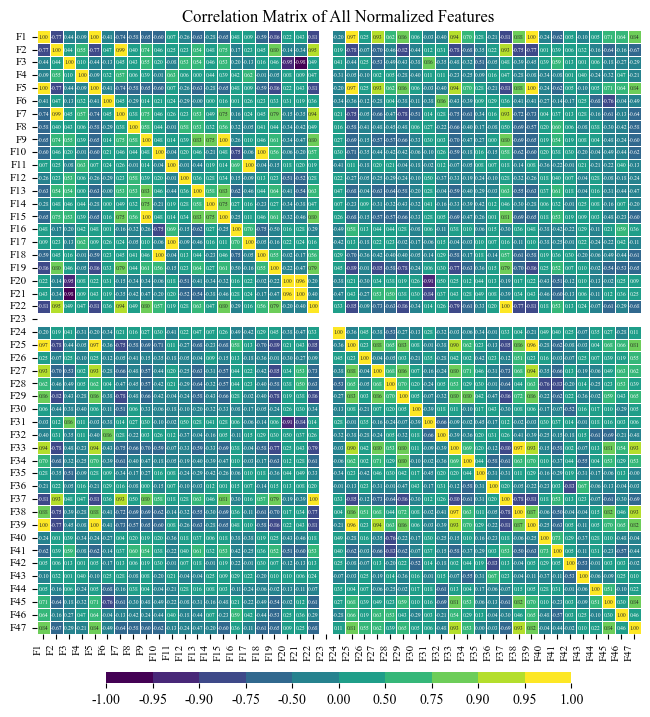

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# Set font to Times New Roman globally
plt.rcParams["font.family"] = "Times New Roman"

# Define font sizes
title_fontsize = 12
label_fontsize = 10
tick_fontsize = 8
cbar_fontsize = 10
annot_fontsize = 4  # Font size for numbers inside boxes

# Ensure feature_headers aligns correctly with features_normalized
feature_headers_1 = [f"F{i+1}" for i in range(features_normalized.shape[1])]  # Rename features to F1, F2, F3,...

# Debugging: Ensure no mismatch
print(f"Features_normalized shape: {features_normalized.shape}")  # Should match headers count
print(f"Feature headers count: {len(feature_headers_1)}")  # Should match columns in features_normalized

# Ensure feature headers and feature data are aligned
if features_normalized.shape[1] != len(feature_headers_1):
    raise ValueError(
        f"Mismatch: features_normalized has {features_normalized.shape[1]} features, "
        f"but headers imply {len(feature_headers_1)}."
    )

# Create DataFrame with renamed normalized features
normalized_features_df_1 = pd.DataFrame(features_normalized, columns=feature_headers_1)

# Compute the correlation matrix
correlation_matrix = normalized_features_df_1.corr()

# 📌 Step 1: Define Custom Discrete Colormap
cmap_colors = [
    "#440154", "#482878", "#3E4989", "#31688E", "#26828E",  # Sharp transition for negative correlations
    "#1F9E89", "#35B779", "#6DCD59", "#B4DE2C", "#FDE725"   # Sharp transition for positive correlations
]
cmap = mcolors.ListedColormap(cmap_colors)

# Define bins for coloring based on correlation strength
bounds = [-1.0, -0.95, -0.90, -0.75, -0.50, 0, 0.50, 0.75, 0.90, 0.95, 1.0]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# 📌 Step 2: Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 9.8))
heatmap = sns.heatmap(
    correlation_matrix,
    cmap=cmap,  # Use custom colormap
    norm=norm,  # Apply binning to enforce color ranges
    annot=True,  # Show numbers inside boxes
    fmt=".2f",  # Format numbers to 2 decimal places
    annot_kws={"size": annot_fontsize},  # Set font size for annotations
    linewidths=0.5,  # Grid lines
    square=True,  # Keep it square
    cbar=True,  # Ensure only one colorbar is added
    cbar_kws={"orientation": "horizontal", "shrink": 0.6, "pad": 0.05, "aspect": 40},  # Adjusted color bar position
    xticklabels=feature_headers_1,  # Feature names F1, F2, ...
    yticklabels=feature_headers_1   # Feature names F1, F2, ...
)

# 📌 Step 3: Ensure all range numbers appear on color bar
cbar = heatmap.collections[0].colorbar
cbar.set_ticks(bounds)  # Set ticks to show all defined ranges
cbar.set_ticklabels([f"{b:.2f}" for b in bounds])  # Label each tick with its corresponding value
cbar.ax.tick_params(labelsize=cbar_fontsize)  # Set color bar font size

# 📌 Step 4: Improve visibility of feature names
plt.xticks(rotation=90, ha="right", fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

# 📌 Step 5: Improve visibility of labels
plt.title("Correlation Matrix of All Normalized Features", fontsize=title_fontsize)

# Show the plot
plt.show()


In [63]:
import pandas as pd
import numpy as np

# Compute the correlation matrix
correlation_matrix = normalized_features_df.corr()

# Define the correlation threshold
correlation_threshold = 0.95

# Get the absolute correlation matrix (ignoring sign)
correlation_matrix_abs = correlation_matrix.abs()

# Mask the diagonal values (self-correlation)
np.fill_diagonal(correlation_matrix_abs.values, 0)

# Find feature pairs where correlation > threshold
high_correlation_pairs = [
    (correlation_matrix_abs.index[i], correlation_matrix_abs.columns[j], correlation_matrix_abs.iloc[i, j])
    for i in range(correlation_matrix_abs.shape[0])
    for j in range(i + 1, correlation_matrix_abs.shape[1])  # Avoid duplicate pairs
    if correlation_matrix_abs.iloc[i, j] > correlation_threshold
]

# Convert to DataFrame for better readability
high_correlation_df = pd.DataFrame(high_correlation_pairs, columns=["Feature 1", "Feature 2", "Correlation"])

# Print the highly correlated feature pairs in a readable format
print("\nHighly Correlated Feature Pairs (|correlation| > 0.95):")
print(high_correlation_df.to_string(index=False))



Highly Correlated Feature Pairs (|correlation| > 0.95):
                   Feature 1                    Feature 2  Correlation
    F1: Reconstruction Error F5: Mean Bin Midpoints Error     1.000000
    F1: Reconstruction Error       F25: Neg Integral Diff     0.965707
    F1: Reconstruction Error       F27: Neg Integral Fdif     0.952631
    F1: Reconstruction Error            F39: Var FFT Diff     0.999663
F2: Mean Bin Midpoints Input            F7: Avg KDE Input     0.994616
 F3: Mean Bin Midpoints Diff     F21: Mean Diff Pred-Diff     0.981916
F5: Mean Bin Midpoints Error       F25: Neg Integral Diff     0.965707
F5: Mean Bin Midpoints Error       F27: Neg Integral Fdif     0.952631
F5: Mean Bin Midpoints Error            F39: Var FFT Diff     0.999663
 F9: Peak Bin Position Input    F15: Peak Diff Input-Fdif     0.999048
 F10: Peak Bin Position Diff     F18: Peak Diff Diff-Fdif     0.997550
 F11: Peak Bin Position Pred     F17: Peak Diff Pred-Fdif     0.997507
   F20: Mean Diff In

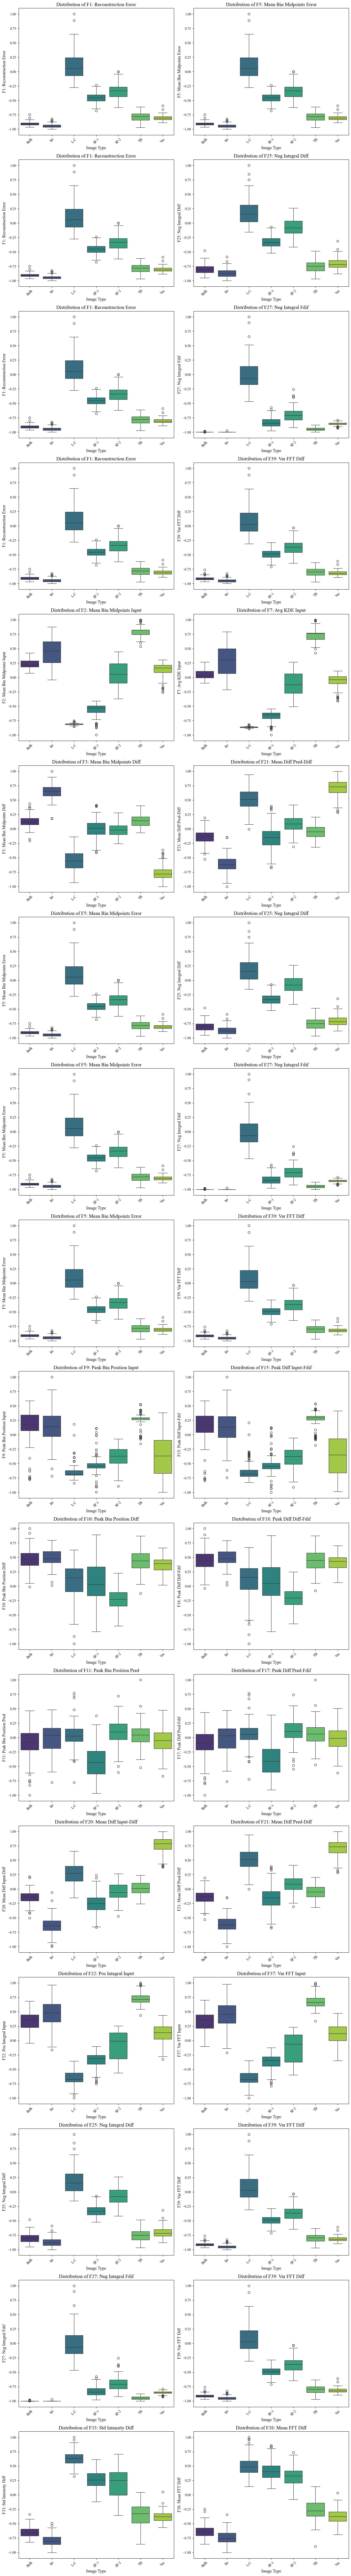

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Number of highly correlated feature pairs
num_pairs = len(high_correlation_pairs)

# Set up the grid of subplots (2 columns, one for each feature in a pair)
num_cols = 2
num_rows = num_pairs  # Each pair occupies one row

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, num_rows * 6), sharex=False)

# Ensure axes is always a 2D array for easy indexing
if num_rows == 1:
    axes = np.array([axes])  # Convert to 2D array if there's only one row

# Plot each highly correlated feature pair
for i, (feature1, feature2, _) in enumerate(high_correlation_pairs):
    # Plot first feature
    sns.boxplot(
        data=df_features_normalized, 
        x='Type', 
        y=feature1, 
        hue='Type',  # ✅ Assign hue to match x-axis categories
        palette='viridis', 
        legend=False,  # ✅ Disable redundant legend
        ax=axes[i, 0]
    )
    axes[i, 0].set_title(f"Distribution of {feature1}", fontsize=14)
    axes[i, 0].set_xlabel("Image Type", fontsize=12)
    axes[i, 0].set_ylabel(feature1, fontsize=12)
    axes[i, 0].tick_params(axis='x', rotation=45)

    # Plot second feature
    sns.boxplot(
        data=df_features_normalized, 
        x='Type', 
        y=feature2, 
        hue='Type',  # ✅ Assign hue to match x-axis categories
        palette='viridis', 
        legend=False,  # ✅ Disable redundant legend
        ax=axes[i, 1]
    )
    axes[i, 1].set_title(f"Distribution of {feature2}", fontsize=14)
    axes[i, 1].set_xlabel("Image Type", fontsize=12)
    axes[i, 1].set_ylabel(feature2, fontsize=12)
    axes[i, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [65]:
from collections import Counter

# Flatten the list of features from correlated pairs
all_correlated_features = [feature for pair in high_correlation_pairs for feature in pair[:2]]

# Count occurrences of each feature in correlated pairs
feature_counts = Counter(all_correlated_features)

# Identify features that occur in multiple pairs (priority retention)
high_occurrence_features = {feature for feature, count in feature_counts.items() if count > 1}

# Create sets for retained and dropped features
retained_features = set(high_occurrence_features)  # Start by keeping frequently occurring features
dropped_features = set()

# Process each correlated pair and drop exactly one feature per pair
for feature1, feature2, _ in high_correlation_pairs:
    if feature1 in retained_features and feature2 in retained_features:
        # If both are in high-occurrence, drop the less frequent one
        if feature_counts[feature1] >= feature_counts[feature2]:
            dropped_features.add(feature2)
        else:
            dropped_features.add(feature1)

    elif feature1 in retained_features:
        # Drop the other if one is a high-occurrence feature
        dropped_features.add(feature2)
    elif feature2 in retained_features:
        dropped_features.add(feature1)
    else:
        # If neither is in high-occurrence, retain the more frequent one
        if feature_counts[feature1] >= feature_counts[feature2]:
            retained_features.add(feature1)
            dropped_features.add(feature2)
        else:
            retained_features.add(feature2)
            dropped_features.add(feature1)

# Ensure dropped features are completely removed
final_retained_features = retained_features.copy()

# Keep only retained and uncorrelated features
shortlisted_features = [
    f for f in feature_headers if f in final_retained_features or f not in all_correlated_features
]

# Remove dropped features from the shortlist
shortlisted_features = [f for f in shortlisted_features if f not in dropped_features]

# Get indices of dropped and shortlisted features
dropped_features_with_indices = sorted(
    [(feature_headers.index(f), f) for f in dropped_features if f in feature_headers], key=lambda x: x[0]
)
shortlisted_features_with_indices = sorted(
    [(feature_headers.index(f), f) for f in shortlisted_features if f in feature_headers], key=lambda x: x[0]
)

# Convert to DataFrame for better display
df_dropped = pd.DataFrame(dropped_features_with_indices, columns=["Index", "Dropped Feature"])
df_shortlisted = pd.DataFrame(shortlisted_features_with_indices, columns=["Index", "Shortlisted Feature"])

# Print the results
print("\nDropped Features:")
print(df_dropped.to_string(index=False))

print("\nShortlisted Features:")
print(df_shortlisted.to_string(index=False))

# Convert the shortlisted feature array
features_shortlisted = df_features_normalized[shortlisted_features].values



Dropped Features:
 Index              Dropped Feature
     2  F3: Mean Bin Midpoints Diff
     4 F5: Mean Bin Midpoints Error
     6            F7: Avg KDE Input
    14    F15: Peak Diff Input-Fdif
    16     F17: Peak Diff Pred-Fdif
    17     F18: Peak Diff Diff-Fdif
    19    F20: Mean Diff Input-Diff
    24       F25: Neg Integral Diff
    26       F27: Neg Integral Fdif
    36           F37: Var FFT Input
    37           F38: Mean FFT Diff
    38            F39: Var FFT Diff

Shortlisted Features:
 Index          Shortlisted Feature
     0     F1: Reconstruction Error
     1 F2: Mean Bin Midpoints Input
     3  F4: Mean Bin Midpoints Pred
     5       F6: Max Bin Count Diff
     7             F8: Avg KDE Diff
     8  F9: Peak Bin Position Input
     9  F10: Peak Bin Position Diff
    10  F11: Peak Bin Position Pred
    11  F12: Peak Bin Position Fdif
    12    F13: Peak Diff Input-Pred
    13    F14: Peak Diff Input-Diff
    15     F16: Peak Diff Pred-Diff
    18    F19: Mean Di

In [66]:
import pandas as pd
import numpy as np

# Convert the shortlisted features back to a DataFrame
shortlisted_features_df = pd.DataFrame(features_shortlisted, columns=shortlisted_features)

# Compute the correlation matrix for the shortlisted features
correlation_matrix = shortlisted_features_df.corr()

# # Define the correlation threshold
# correlation_threshold = 0.95

# Get the absolute correlation matrix (ignoring sign)
correlation_matrix_abs = correlation_matrix.abs()

# Mask the diagonal values (self-correlation)
np.fill_diagonal(correlation_matrix_abs.values, 0)

# Find feature pairs where correlation > threshold
high_correlation_pairs = [
    (correlation_matrix_abs.index[i], correlation_matrix_abs.columns[j], correlation_matrix_abs.iloc[i, j])
    for i in range(correlation_matrix_abs.shape[0])
    for j in range(i + 1, correlation_matrix_abs.shape[1])  # Avoid duplicate pairs
    if correlation_matrix_abs.iloc[i, j] > correlation_threshold
]

# Convert to DataFrame for better readability
high_correlation_df = pd.DataFrame(high_correlation_pairs, columns=["Feature 1", "Feature 2", "Correlation"])

# Print the highly correlated feature pairs in a readable format
if high_correlation_df.empty:
    print("\n✅ No highly correlated feature pairs remain (|correlation| > 0.95).")
else:
    print("\n❌ Highly Correlated Feature Pairs (|correlation| > 0.95):")
    print(high_correlation_df.to_string(index=False))

    # Save the table as a CSV file for further analysis
    high_correlation_df.to_csv("highly_correlated_features_after_shortlisting.csv", index=False)



✅ No highly correlated feature pairs remain (|correlation| > 0.95).


In [67]:
# Get the total number of shortlisted features
num_shortlisted_features = len(shortlisted_features)

# Create a DataFrame for better display
df_shortlisted = pd.DataFrame(
    {"Index": range(num_shortlisted_features), "Feature Name": shortlisted_features}
)

# Print the total number of shortlisted features
print(f"\nTotal Number of Shortlisted Features: {num_shortlisted_features}\n")

# Print the indexed feature list
print(df_shortlisted.to_string(index=False))



Total Number of Shortlisted Features: 35

 Index                 Feature Name
     0     F1: Reconstruction Error
     1 F2: Mean Bin Midpoints Input
     2  F4: Mean Bin Midpoints Pred
     3       F6: Max Bin Count Diff
     4             F8: Avg KDE Diff
     5  F9: Peak Bin Position Input
     6  F10: Peak Bin Position Diff
     7  F11: Peak Bin Position Pred
     8  F12: Peak Bin Position Fdif
     9    F13: Peak Diff Input-Pred
    10    F14: Peak Diff Input-Diff
    11     F16: Peak Diff Pred-Diff
    12    F19: Mean Diff Input-Pred
    13     F21: Mean Diff Pred-Diff
    14      F22: Pos Integral Input
    15      F23: Neg Integral Input
    16       F24: Pos Integral Diff
    17       F26: Pos Integral Fdif
    18          F28: Skewness Input
    19          F29: Kurtosis Input
    20     F30: Std Intensity Input
    21           F31: Skewness Diff
    22           F32: Kurtosis Diff
    23      F33: Std Intensity Diff
    24    F34: Largest Region Input
    25     F35: Large

In [68]:
best_pca_dims, best_num_clusters, best_kmeans, best_score = optimize_pca_and_kmeans(
    features_shortlisted,  
    max_pca_dims=max_pca_dims, 
    max_clusters=max_clusters, 
    variance_threshold=variance_threshold
)

print(f"Optimal number of PCA dimensions: {best_pca_dims}")
print(f"Optimal number of clusters: {best_num_clusters}")
print(f"Best silhouette score: {best_score:.4f}")

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Optimal number of PCA dimensions: 9
Optimal number of clusters: 7
Best silhouette score: 0.4382


C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



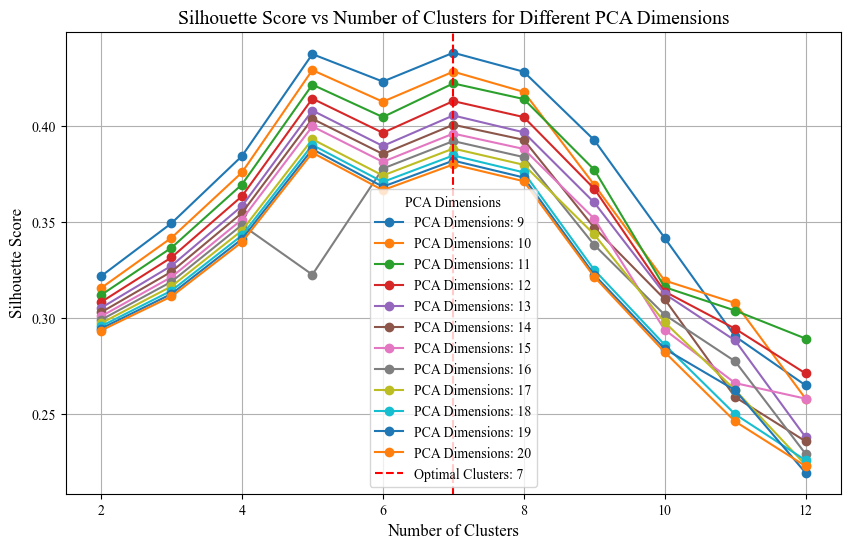

In [69]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Collect scores for plotting
cluster_range = range(2, max_clusters + 1)
pca_range = range(2, max_pca_dims + 1)
results = []

# Iterate over PCA dimensions and cluster counts to compute silhouette scores
for pca_dims in pca_range:
    pca = PCA(n_components=pca_dims)
    pca_features = pca.fit_transform(features_shortlisted)

    explained_variance = np.sum(pca.explained_variance_ratio_)
    if explained_variance < variance_threshold:
        continue

    pca_scores = []
    for num_clusters in cluster_range:
        #kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(pca_features)
        score = silhouette_score(pca_features, cluster_labels)
        pca_scores.append(score)

    results.append((pca_dims, pca_scores))

# Plot silhouette scores
plt.figure(figsize=(10, 6))
for pca_dims, scores in results:
    plt.plot(cluster_range, scores, marker='o', label=f'PCA Dimensions: {pca_dims}')

plt.axvline(x=best_num_clusters, color='r', linestyle='--', label=f'Optimal Clusters: {best_num_clusters}')
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score vs Number of Clusters for Different PCA Dimensions', fontsize=14)
plt.legend(title='PCA Dimensions', fontsize=10)
plt.grid()
plt.show()

In [70]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd

# Use the optimal number of PCA dimensions and clusters obtained earlier
pca = PCA(n_components=best_pca_dims)
pca_features_optimized = pca.fit_transform(features_shortlisted)
pca_columns = [f'PCA_{i+1}' for i in range(best_pca_dims)]

# Create a DataFrame for PCA-transformed features
df_features = pd.DataFrame(pca_features_optimized, columns=pca_columns)
df_features['Cluster'] = best_kmeans.labels_
df_features['Filename'] = image_filenames

df_features['Type'] = df_features['Filename'].apply(
    lambda x: 'Bulk' if x.startswith('Bulk') and not x.startswith('BulkDefect') 
    else 'L-C' if x.startswith('LC') 
    else 'Int' if x.startswith('interstitial') 
    else 'Vac' if x.startswith('Vacancy_CdTe')
    else 'SF-1' if x.startswith('SF1')
    else 'SF-2' if x.startswith('SF2')
    else 'TB' if x.startswith('Twin_Bound')
    #else 'Other'
    else None
)
markers = {
    'Bulk': 'o', 'L-C': 'v', 'Int': 'd', 'Vac': 's', 
    'SF-1': '*', 'SF-2': 'p', 'TB': '^'
}

colors = {
    'Bulk': 'r', 'L-C': 'g', 'Int': 'b', 'Vac': 'c', 
    'SF-1': 'brown', 'SF-2': 'm', 'TB': 'y'
}


In [71]:
# Initialize variables for accuracy tracking
cluster_accuracies = []

print("\nCluster Accuracy Details:\n")

# Loop through each cluster to calculate accuracy and list filenames
for cluster in range(best_num_clusters):
    # Filter data for the current cluster
    cluster_df = df_features[df_features['Cluster'] == cluster]

    if len(cluster_df) == 0:
        print(f"Cluster {cluster} is empty.\n")
        cluster_accuracies.append(0)
        continue

    # Find the most frequent image type in the cluster
    most_frequent_type = cluster_df['Type'].mode()[0]
    most_frequent_type_count = cluster_df['Type'].value_counts().get(most_frequent_type, 0)

    # Calculate accuracy for the cluster
    cluster_accuracy = (most_frequent_type_count / len(cluster_df)) * 100
    cluster_accuracies.append(cluster_accuracy)

    # Print details of the cluster
    print(f"Cluster {cluster}:")
    print(f"Image Names: {', '.join(cluster_df['Filename'].values)}")
    print(f"Image Type Counts:\n{cluster_df['Type'].value_counts()}")
    print(f"Most Frequent Type: {most_frequent_type}")
    print(f"Accuracy of Cluster {cluster}: {cluster_accuracy:.2f}%\n")

# Calculate overall accuracy
overall_accuracy = np.mean(cluster_accuracies)
print(f"Overall Clustering Accuracy: {overall_accuracy:.2f}%\n")



Cluster Accuracy Details:

Cluster 0:
Image Names: LC_0.tif, LC_1.tif, LC_10.tif, LC_100.tif, LC_101.tif, LC_102.tif, LC_103.tif, LC_104.tif, LC_105.tif, LC_106.tif, LC_107.tif, LC_108.tif, LC_109.tif, LC_11.tif, LC_110.tif, LC_111.tif, LC_112.tif, LC_113.tif, LC_114.tif, LC_115.tif, LC_116.tif, LC_117.tif, LC_118.tif, LC_119.tif, LC_12.tif, LC_120.tif, LC_121.tif, LC_122.tif, LC_123.tif, LC_124.tif, LC_125.tif, LC_126.tif, LC_127.tif, LC_128.tif, LC_129.tif, LC_13.tif, LC_130.tif, LC_131.tif, LC_132.tif, LC_133.tif, LC_134.tif, LC_135.tif, LC_136.tif, LC_137.tif, LC_138.tif, LC_139.tif, LC_14.tif, LC_140.tif, LC_141.tif, LC_142.tif, LC_143.tif, LC_144.tif, LC_145.tif, LC_146.tif, LC_147.tif, LC_148.tif, LC_149.tif, LC_15.tif, LC_150.tif, LC_151.tif, LC_152.tif, LC_153.tif, LC_154.tif, LC_155.tif, LC_156.tif, LC_157.tif, LC_158.tif, LC_159.tif, LC_16.tif, LC_160.tif, LC_161.tif, LC_162.tif, LC_163.tif, LC_164.tif, LC_165.tif, LC_166.tif, LC_167.tif, LC_168.tif, LC_169.tif, LC_17.tif, 

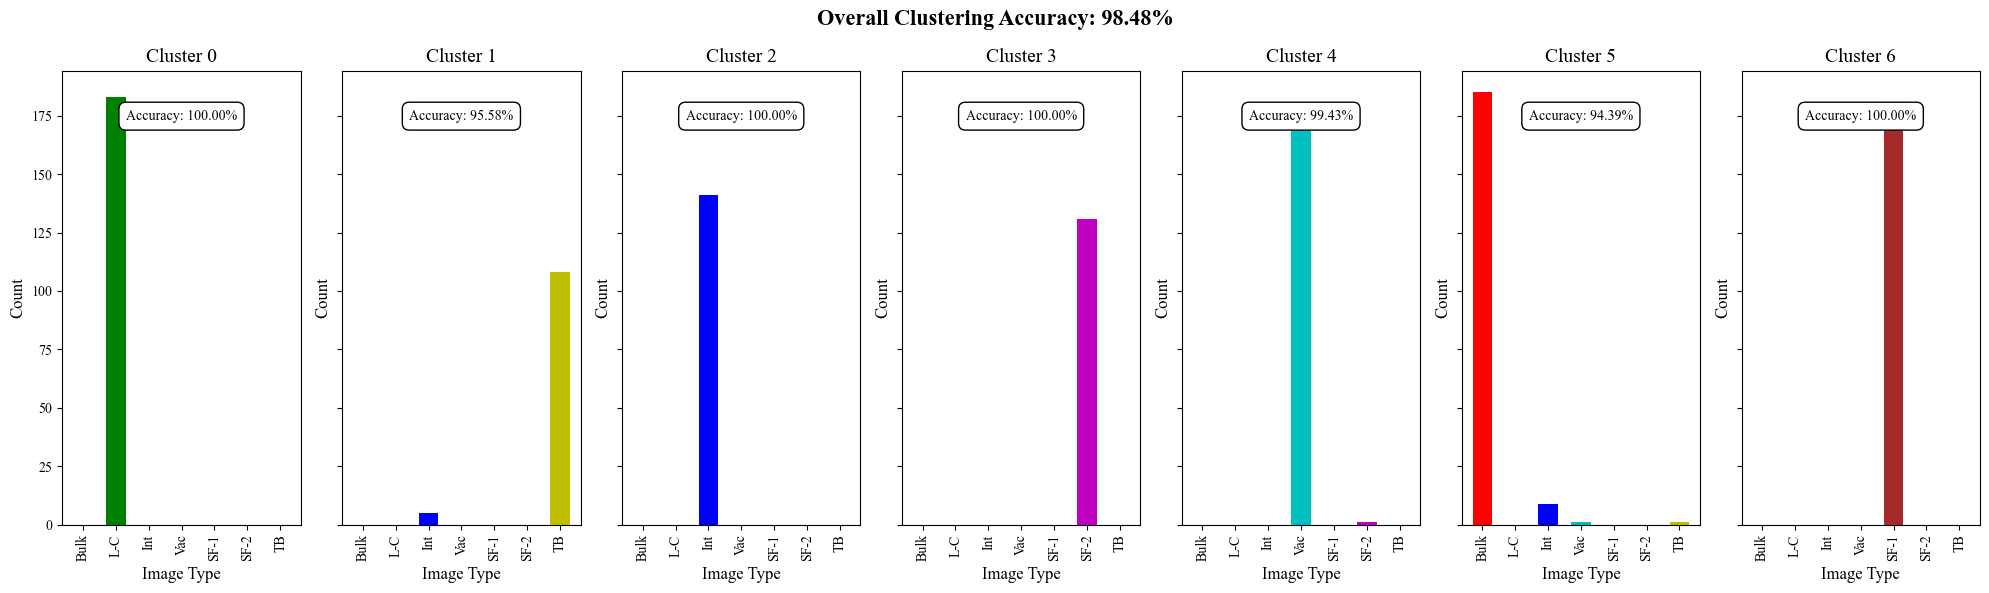

In [72]:
import matplotlib.pyplot as plt

# Create subplots for histograms of each cluster
fig, axes = plt.subplots(1, best_num_clusters, figsize=(20, 6), sharey=True)

for cluster in range(best_num_clusters):
    # Filter data for the current cluster
    cluster_df = df_features[df_features['Cluster'] == cluster]

    # Skip empty clusters
    if len(cluster_df) == 0:
        continue

    # Ensure all image types are present in the histogram, even if count is zero
    type_counts = cluster_df['Type'].value_counts().reindex(markers.keys(), fill_value=0)

    # Plot the histogram for the current cluster
    ax = axes[cluster]
    bars = ax.bar(
        type_counts.index, 
        type_counts.values, 
        color=[colors[t] for t in type_counts.index], 
        width=0.6
    )

    # Set title and labels for the current subplot
    ax.set_title(f"Cluster {cluster}", fontsize=14)
    ax.set_xlabel('Image Type', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x', rotation=90, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    # Add accuracy text for the cluster
    cluster_accuracy = cluster_accuracies[cluster]
    ax.text(
        0.5, 0.9, 
        f"Accuracy: {cluster_accuracy:.2f}%", 
        ha='center', va='center', transform=ax.transAxes, fontsize=10, 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
    )

# Add overall accuracy text as a figure title
plt.suptitle(f"Overall Clustering Accuracy: {overall_accuracy:.2f}%", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


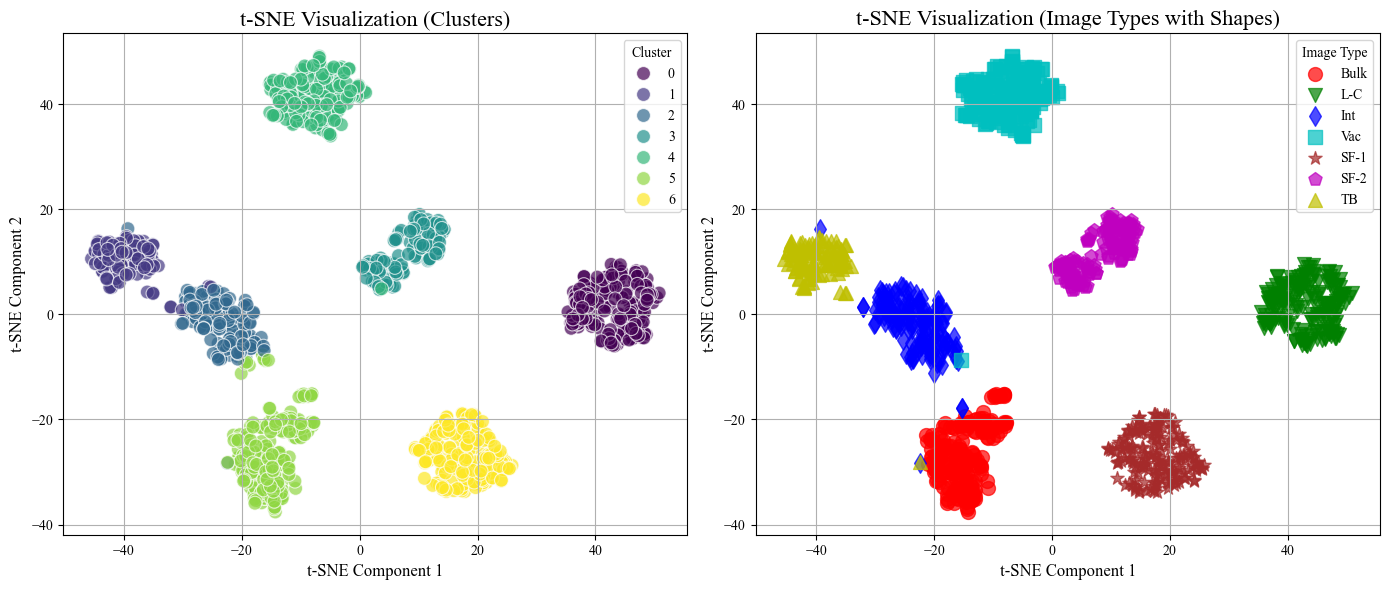

In [73]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Apply t-SNE to reduce the optimal PCA features to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(pca_features_optimized)

# Add t-SNE components to the DataFrame for easier access
df_features['t-SNE1'] = tsne_features[:, 0]
df_features['t-SNE2'] = tsne_features[:, 1]

# Create the figure
plt.figure(figsize=(14, 6))

# Plot 1: Clusters (Color-Coded by Cluster)
plt.subplot(1, 2, 1)
sns.scatterplot(
    x='t-SNE1', 
    y='t-SNE2', 
    hue='Cluster', 
    data=df_features, 
    palette='viridis', 
    s=100,  # Point size
    alpha=0.7
)
plt.title("t-SNE Visualization (Clusters)", fontsize=16)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(title="Cluster", fontsize=10)
plt.grid()

# Plot 2: Image Types (Legends with Shapes and Colors)
plt.subplot(1, 2, 2)
for img_type in markers:
    subset = df_features[df_features['Type'] == img_type]
    plt.scatter(
        subset['t-SNE1'], 
        subset['t-SNE2'], 
        marker=markers[img_type],  # Shape based on image type
        color=colors[img_type],   # Color based on image type
        label=img_type,
        alpha=0.7,
        s=100  # Point size
    )
plt.title("t-SNE Visualization (Image Types with Shapes)", fontsize=16)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(title="Image Type", fontsize=10)
plt.grid()

# Adjust layout
plt.tight_layout()
plt.show()


# Further feature shortlisting based on silhouete score

#Dropping only those features having silhoute score = -1 

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th


Silhouette Scores for Shortlisted Features:

 Index                 Feature Name  Silhouette Score  Optimal Clusters  Small Clusters Flag  Low Variance Flag
    22           F32: Kurtosis Diff          0.783143                 2                False              False
    21           F31: Skewness Diff          0.775418                 2                False              False
     4             F8: Avg KDE Diff          0.751296                 2                 True              False
     1 F2: Mean Bin Midpoints Input          0.734265                 4                False              False
     3       F6: Max Bin Count Diff          0.725219                 2                False              False
    17       F26: Pos Integral Fdif          0.717142                 2                False              False
     0     F1: Reconstruction Error          0.714438                 3                False              False
    19          F29: Kurtosis Input          0.714014     

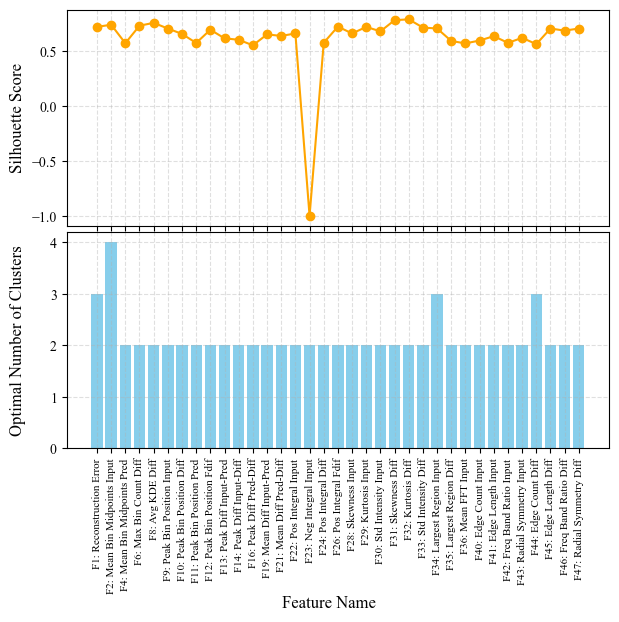

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set global font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Initialize lists to store results
optimal_num_clusters = []
silhouette_scores = []
small_cluster_flags = []
low_variance_flags = []

# Define threshold for small clusters
min_cluster_size_threshold = 2  # Adjust based on dataset size

# Iterate through each feature in the shortlisted feature array
for feature_idx, feature_name in enumerate(shortlisted_features):
    feature_data = features_shortlisted[:, feature_idx].reshape(-1, 1)
    best_score = -1
    best_k = 2
    max_clusters = min(len(feature_data), max_clusters)

    # Compute variance to check for low-variance features
    variance = np.var(feature_data)
    low_variance = variance < 1e-3  # Define a small threshold for variance

    try:
        for k in range(2, max_clusters + 1):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(feature_data)

            # Check for small clusters
            unique_labels, counts = np.unique(cluster_labels, return_counts=True)
            small_clusters = np.any(counts < min_cluster_size_threshold)

            # Compute silhouette score
            if len(np.unique(cluster_labels)) > 1:
                score = silhouette_score(feature_data, cluster_labels)

                if score > best_score:
                    best_score = score
                    best_k = k

        # Store results
        optimal_num_clusters.append(best_k)
        silhouette_scores.append(best_score)
        small_cluster_flags.append(small_clusters)
        low_variance_flags.append(low_variance)

    except Exception:
        optimal_num_clusters.append(0)
        silhouette_scores.append(0)
        small_cluster_flags.append(False)
        low_variance_flags.append(False)

# Create DataFrame for results
df_silhouette = pd.DataFrame({
    "Index": range(len(silhouette_scores)),
    "Feature Name": shortlisted_features,
    "Silhouette Score": silhouette_scores,
    "Optimal Clusters": optimal_num_clusters,
    "Small Clusters Flag": small_cluster_flags,
    "Low Variance Flag": low_variance_flags
}).sort_values(by="Silhouette Score", ascending=False)

# Print the silhouette scores table
print("\nSilhouette Scores for Shortlisted Features:\n")
print(df_silhouette.to_string(index=False))

# Plot the silhouette scores for each feature
fig, axes = plt.subplots(2, 1, figsize=(7, 5.7), sharex=True, gridspec_kw={'hspace': 0.03})
axes[0].plot(shortlisted_features, silhouette_scores, marker='o', color='orange')

axes[0].set_ylabel("Silhouette Score", fontsize=12)
#axes[0].set_title("Silhouette Score for Each Feature", fontsize=14)
axes[0].tick_params(axis='x', rotation=90, labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)
axes[0].grid(alpha=0.4, linestyle='--')




# Plot the optimal number of clusters for each feature

axes[1].bar(shortlisted_features, optimal_num_clusters, color='skyblue')

axes[1].set_ylabel("Optimal Number of Clusters", fontsize=12, labelpad=17)
#axes[1].set_title("Optimal Number of Clusters for Each Feature", fontsize=14)
axes[1].tick_params(axis='x', rotation=90, labelsize=8)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].grid(alpha=0.4, linestyle='--')
fig.text(0.5, -0.17, "Feature Name", ha='center', fontsize=12, fontname='Times New Roman')
plt.show()


In [75]:
# Convert the lists to a DataFrame for easy filtering
df_silhouette_filtered = df_silhouette[df_silhouette["Silhouette Score"] >= 0]

# Get indices of features to keep
features_to_keep_indices = df_silhouette_filtered["Index"].values

# Create the new feature array by selecting only the kept features
features_filtered = features_shortlisted[:, features_to_keep_indices]

# Print the shape of the new feature array
print("Shape of new feature array:", features_filtered.shape)


Shape of new feature array: (1119, 34)


In [76]:
best_pca_dims, best_num_clusters, best_kmeans, best_score = optimize_pca_and_kmeans(
    features_filtered,  # Now using filtered features
    max_pca_dims=max_pca_dims, 
    max_clusters=max_clusters, 
    variance_threshold=variance_threshold
)

print(f"Optimal number of PCA dimensions: {best_pca_dims}")
print(f"Optimal number of clusters: {best_num_clusters}")
print(f"Best silhouette score: {best_score:.4f}")


C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Optimal number of PCA dimensions: 9
Optimal number of clusters: 7
Best silhouette score: 0.4382


C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



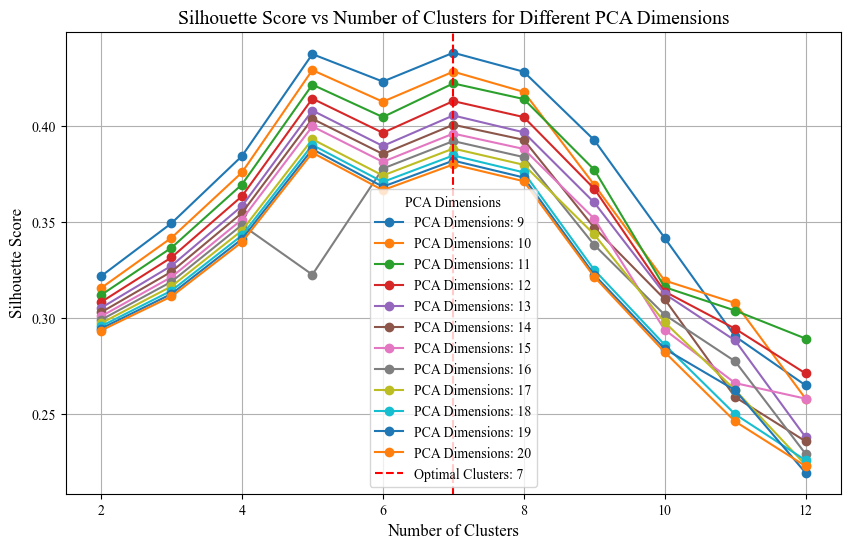

In [77]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Collect scores for plotting
cluster_range = range(2, max_clusters + 1)
#cluster_range = range(2, 12 + 1)
pca_range = range(2, min(max_pca_dims, features_filtered.shape[1]) + 1)  # Ensure PCA dims do not exceed available features
results = []

# Iterate over PCA dimensions and cluster counts to compute silhouette scores
for pca_dims in pca_range:
    pca = PCA(n_components=pca_dims)
    pca_features = pca.fit_transform(features_filtered)  # Use filtered features

    explained_variance = np.sum(pca.explained_variance_ratio_)
    if explained_variance < variance_threshold:
        continue

    pca_scores = []
    for num_clusters in cluster_range:
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(pca_features)
        score = silhouette_score(pca_features, cluster_labels)
        pca_scores.append(score)

    results.append((pca_dims, pca_scores))

# Plot silhouette scores
plt.figure(figsize=(10, 6))
for pca_dims, scores in results:
    plt.plot(cluster_range, scores, marker='o', label=f'PCA Dimensions: {pca_dims}')

# Mark the optimal number of clusters
plt.axvline(x=best_num_clusters, color='r', linestyle='--', label=f'Optimal Clusters: {best_num_clusters}')

# Labels and title
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score vs Number of Clusters for Different PCA Dimensions', fontsize=14)
plt.legend(title='PCA Dimensions', fontsize=10)
plt.grid()
plt.show()


In [78]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Use the optimal number of PCA dimensions and clusters obtained earlier
pca = PCA(n_components=best_pca_dims)
pca_features_optimized = pca.fit_transform(features_filtered)  # Now using filtered features
pca_columns = [f'PCA_{i+1}' for i in range(best_pca_dims)]

# Create a DataFrame for PCA-transformed features
df_features = pd.DataFrame(pca_features_optimized, columns=pca_columns)
df_features['Cluster'] = best_kmeans.labels_
df_features['Filename'] = image_filenames  # Assuming image_filenames matches features_filtered rows

# Add Image Type Information
df_features['Type'] = df_features['Filename'].apply(
    lambda x: 'Bulk' if x.startswith('Bulk') and not x.startswith('BulkDefect') 
    else 'L-C' if x.startswith('LC') 
    else 'Int' if x.startswith('interstitial') 
    else 'Vac' if x.startswith('Vacancy_CdTe')
    else 'SF-1' if x.startswith('SF1')
    else 'SF-2' if x.startswith('SF2')
    else 'TB' if x.startswith('Twin_Bound')
    #else 'Other'
    else None
)

markers = {
    'Bulk': 'o', 'L-C': 'v', 'Int': 'd', 'Vac': 's', 
    'SF-1': '*', 'SF-2': 'p', 'TB': '^'
}

colors = {
    'Bulk': 'r', 'L-C': 'g', 'Int': 'b', 'Vac': 'c', 
    'SF-1': 'brown', 'SF-2': 'm', 'TB': 'y'
}



# Initialize variables for accuracy tracking
cluster_accuracies = []

print("\nCluster Accuracy Details:\n")

# Loop through each cluster to calculate accuracy and list filenames
for cluster in range(best_num_clusters):
    # Filter data for the current cluster
    cluster_df = df_features[df_features['Cluster'] == cluster]

    if len(cluster_df) == 0:
        print(f"Cluster {cluster} is empty.\n")
        cluster_accuracies.append(0)
        continue

    # Find the most frequent image type in the cluster
    most_frequent_type = cluster_df['Type'].mode()[0]
    most_frequent_type_count = cluster_df['Type'].value_counts().get(most_frequent_type, 0)

    # Calculate accuracy for the cluster
    cluster_accuracy = (most_frequent_type_count / len(cluster_df)) * 100
    cluster_accuracies.append(cluster_accuracy)

    # Print details of the cluster
    print(f"Cluster {cluster}:")
    print(f"Image Names: {', '.join(cluster_df['Filename'].values)}")
    print(f"Image Type Counts:\n{cluster_df['Type'].value_counts()}")
    print(f"Most Frequent Type: {most_frequent_type}")
    print(f"Accuracy of Cluster {cluster}: {cluster_accuracy:.2f}%\n")

# Calculate overall accuracy
overall_accuracy = np.mean(cluster_accuracies)
print(f"Overall Clustering Accuracy: {overall_accuracy:.2f}%\n")



Cluster Accuracy Details:

Cluster 0:
Image Names: LC_0.tif, LC_1.tif, LC_10.tif, LC_100.tif, LC_101.tif, LC_102.tif, LC_103.tif, LC_104.tif, LC_105.tif, LC_106.tif, LC_107.tif, LC_108.tif, LC_109.tif, LC_11.tif, LC_110.tif, LC_111.tif, LC_112.tif, LC_113.tif, LC_114.tif, LC_115.tif, LC_116.tif, LC_117.tif, LC_118.tif, LC_119.tif, LC_12.tif, LC_120.tif, LC_121.tif, LC_122.tif, LC_123.tif, LC_124.tif, LC_125.tif, LC_126.tif, LC_127.tif, LC_128.tif, LC_129.tif, LC_13.tif, LC_130.tif, LC_131.tif, LC_132.tif, LC_133.tif, LC_134.tif, LC_135.tif, LC_136.tif, LC_137.tif, LC_138.tif, LC_139.tif, LC_14.tif, LC_140.tif, LC_141.tif, LC_142.tif, LC_143.tif, LC_144.tif, LC_145.tif, LC_146.tif, LC_147.tif, LC_148.tif, LC_149.tif, LC_15.tif, LC_150.tif, LC_151.tif, LC_152.tif, LC_153.tif, LC_154.tif, LC_155.tif, LC_156.tif, LC_157.tif, LC_158.tif, LC_159.tif, LC_16.tif, LC_160.tif, LC_161.tif, LC_162.tif, LC_163.tif, LC_164.tif, LC_165.tif, LC_166.tif, LC_167.tif, LC_168.tif, LC_169.tif, LC_17.tif, 

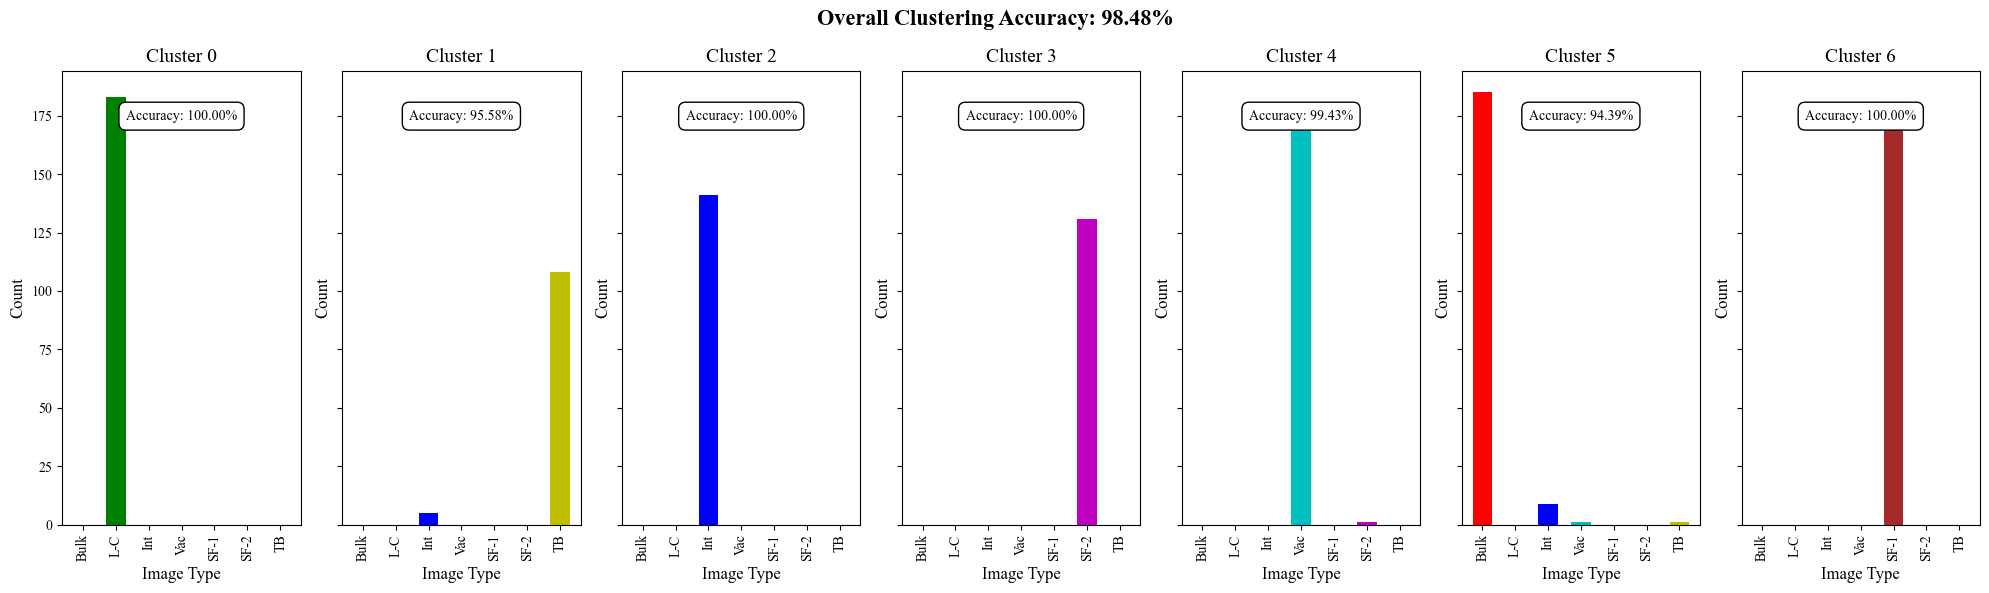

In [79]:
import matplotlib.pyplot as plt

# Create subplots for histograms of each cluster
fig, axes = plt.subplots(1, best_num_clusters, figsize=(20, 6), sharey=True)

# Ensure axes is always iterable (in case there's only one cluster)
if best_num_clusters == 1:
    axes = [axes]

for cluster in range(best_num_clusters):
    # Filter data for the current cluster
    cluster_df = df_features[df_features['Cluster'] == cluster]

    # Skip empty clusters
    if len(cluster_df) == 0:
        continue

    # Ensure all image types are present in the histogram, even if count is zero
    type_counts = cluster_df['Type'].value_counts().reindex(colors.keys(), fill_value=0)

    # Plot the histogram for the current cluster
    ax = axes[cluster]
    bars = ax.bar(
        type_counts.index, 
        type_counts.values, 
        color=[colors[t] for t in type_counts.index], 
        width=0.6
    )

    # Set title and labels for the current subplot
    ax.set_title(f"Cluster {cluster}", fontsize=14)
    ax.set_xlabel('Image Type', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x', rotation=90, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    # Add accuracy text for the cluster
    cluster_accuracy = cluster_accuracies[cluster]
    ax.text(
        0.5, 0.9, 
        f"Accuracy: {cluster_accuracy:.2f}%", 
        ha='center', va='center', transform=ax.transAxes, fontsize=10, 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
    )

# Add overall accuracy text as a figure title
plt.suptitle(f"Overall Clustering Accuracy: {overall_accuracy:.2f}%", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


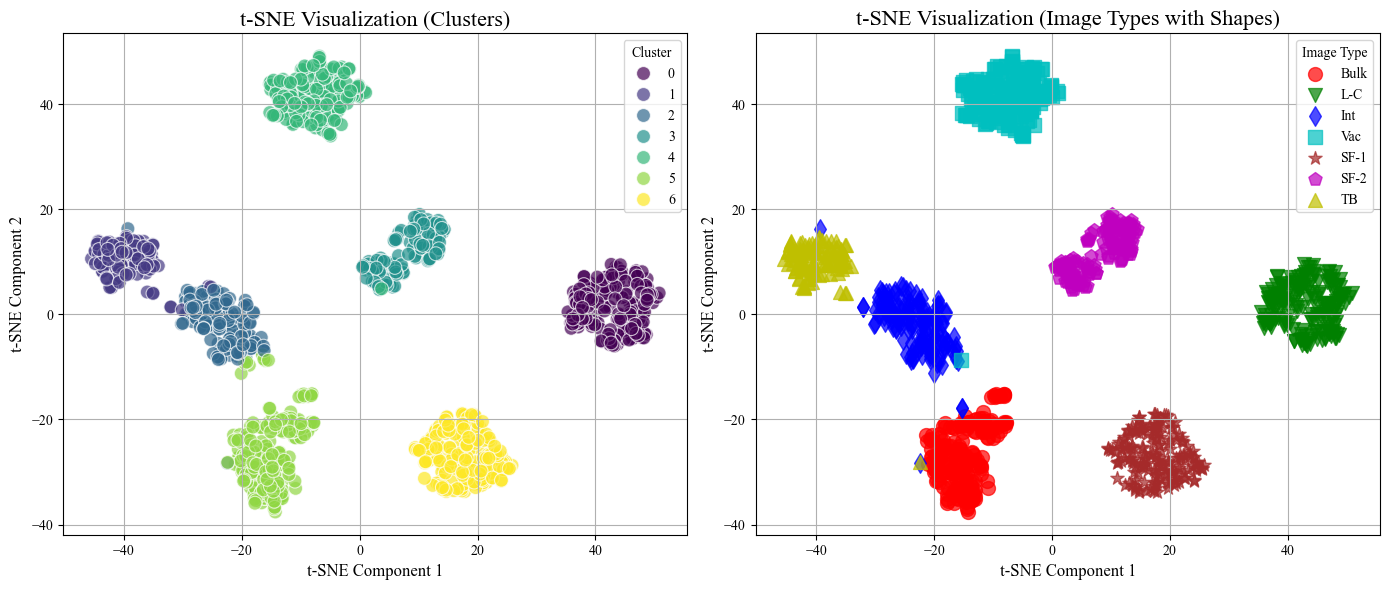

In [80]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Apply t-SNE to reduce the optimal PCA features to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features_filtered) - 1))  
tsne_features = tsne.fit_transform(pca_features_optimized)  # Now using PCA-transformed filtered features

# Add t-SNE components to the DataFrame for easier access
df_features['t-SNE1'] = tsne_features[:, 0]
df_features['t-SNE2'] = tsne_features[:, 1]

# Create the figure
plt.figure(figsize=(14, 6))

# Plot 1: Clusters (Color-Coded by Cluster)
plt.subplot(1, 2, 1)
sns.scatterplot(
    x='t-SNE1', 
    y='t-SNE2', 
    hue='Cluster', 
    data=df_features, 
    palette='viridis', 
    s=100,  # Point size
    alpha=0.7
)
plt.title("t-SNE Visualization (Clusters)", fontsize=16)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(title="Cluster", fontsize=10)
plt.grid()

# Plot 2: Image Types (Legends with Shapes and Colors)
plt.subplot(1, 2, 2)
for img_type in colors:  # Using colors.keys() to match defined image types
    subset = df_features[df_features['Type'] == img_type]
    plt.scatter(
        subset['t-SNE1'], 
        subset['t-SNE2'], 
        marker=markers.get(img_type, 'o'),  # Default to 'o' if type not found
        color=colors[img_type],   # Color based on image type
        label=img_type,
        alpha=0.7,
        s=100  # Point size
    )
plt.title("t-SNE Visualization (Image Types with Shapes)", fontsize=16)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(title="Image Type", fontsize=10)
plt.grid()

# Adjust layout
plt.tight_layout()
plt.show()


# Panel-4: Plot before Variance

In [81]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# # Ensure `features_filtered` is a NumPy array
# features_filtered = np.array(features_filtered)

# # Calculate variance for each feature **before variance-based filtering**
# feature_variances_before = np.var(features_filtered, axis=0)

# # Create a DataFrame for plotting
# df_variance_before = pd.DataFrame({
#     "Feature Name": df_silhouette_filtered["Feature Name"].values,  # Feature names before variance filtering
#     "Variance": feature_variances_before
# })

# # Sort by variance for better visualization
# df_variance_before_sorted = df_variance_before.sort_values(by="Variance", ascending=False)

# # Customize plot settings
# fig, ax = plt.subplots(figsize=(6.4, 3.8))

# # User-defined customization for bar properties
# bar_color = "royalblue"  # Change color here
# bar_width = 0.8  # Adjust width

# # Plot bar chart
# ax.bar(
#     np.arange(len(df_variance_before_sorted)),  # Ensure correct spacing of bars
#     df_variance_before_sorted["Variance"], 
#     color=bar_color, width=bar_width, alpha=0.9
# )

# # Set font to Times New Roman and customize font sizes
# plt.rcParams["font.family"] = "Times New Roman"
# ax.set_xticks(np.arange(len(df_variance_before_sorted)))  # Ensure ticks match data points
# ax.set_xticklabels(df_variance_before_sorted["Feature Name"], rotation=90, fontsize=9)
# ax.set_ylabel("Variance", fontsize=12, fontweight="normal")
# ax.set_xlabel("Features", fontsize=12, fontweight="normal")

# # Adjust grid lines to be darker
# ax.grid(axis="y", linestyle="--", color="black", alpha=0.3)

# # Add plot margins on all sides
# plt.margins(x=0.01, y=0.02)

# # Add plot borders on top and right
# ax.spines["top"].set_visible(True)
# ax.spines["right"].set_visible(True)

# # Apply tight layout with padding
# plt.tight_layout(pad=0.03)

# Save figure with 600 DPI
#plt.savefig("C:/Users/rayyub2/Desktop/Ayyubi/Manuscript_ML_2/Panels/P5/feature_Variance.png", dpi=800, bbox_inches='tight')

# Show the plot
plt.show()


# Variance Thresholding

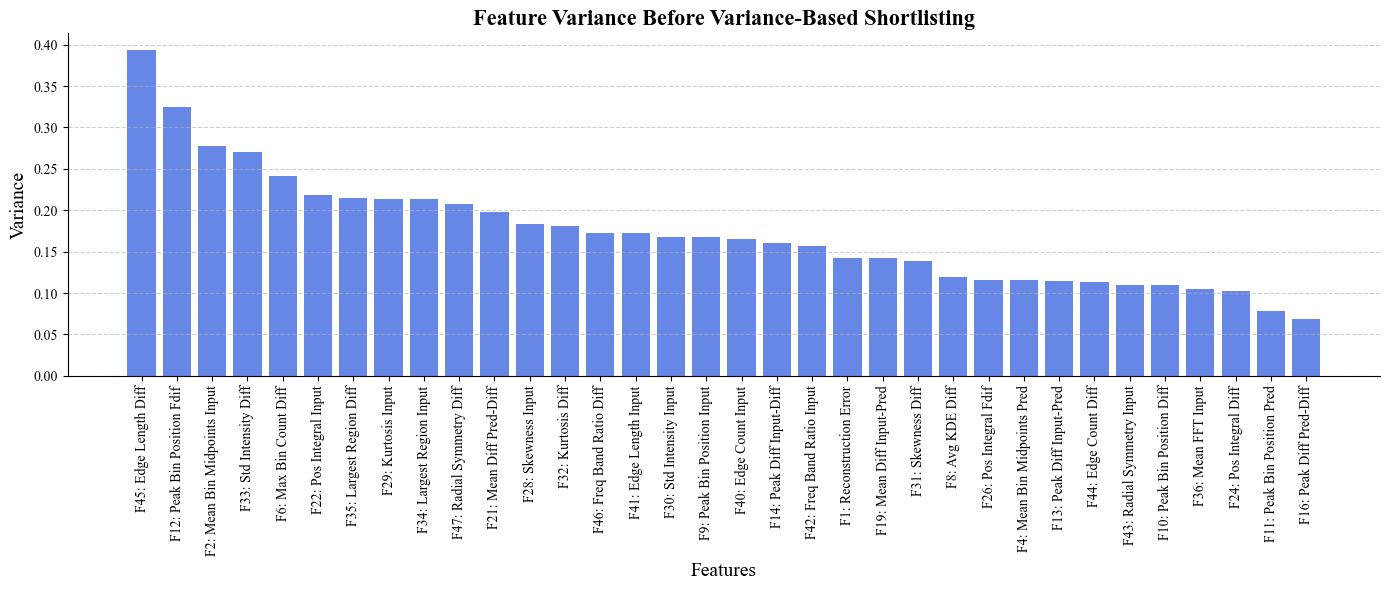

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# # Ensure `features_filtered` is a NumPy array
# features_filtered = np.array(features_filtered)

# Calculate variance for each feature **before variance-based filtering**
feature_variances_before = np.var(features_filtered, axis=0)

# Create a DataFrame for plotting
df_variance_before = pd.DataFrame({
    "Feature Name": df_silhouette_filtered["Feature Name"].values,  # Feature names before variance filtering
    "Variance": feature_variances_before
})

# Sort by variance for better visualization
df_variance_before_sorted = df_variance_before.sort_values(by="Variance", ascending=False)

# Plot settings
plt.figure(figsize=(14, 6))
plt.bar(
    range(len(df_variance_before_sorted)), 
    df_variance_before_sorted["Variance"], 
    color="royalblue", alpha=0.8
)
plt.xticks(
    range(len(df_variance_before_sorted)), 
    df_variance_before_sorted["Feature Name"], 
    rotation=90, fontsize=10
)
plt.ylabel("Variance", fontsize=14)
plt.xlabel("Features", fontsize=14)
plt.title("Feature Variance Before Variance-Based Shortlisting", fontsize=16, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Make the plot more visually appealing
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()


In [83]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd

# 📌 Step 1: Apply Variance Thresholding to `features_filtered` instead of `features_shortlisted`
var_threshold = 0.1  # Remove features with variance < 0.1
var_selector = VarianceThreshold(threshold=var_threshold)
features_variance_filtered = var_selector.fit_transform(features_filtered)

# 📌 Step 2: Get Selected Feature Names
# Find indices of selected features after variance filtering
selected_feature_indices = np.where(var_selector.get_support())[0]

# Ensure df_silhouette_filtered has correct indexing
df_silhouette_filtered = df_silhouette[df_silhouette["Silhouette Score"] != -1].reset_index(drop=True)

# Map back to feature names using `df_silhouette_filtered`
selected_feature_names = df_silhouette_filtered.iloc[selected_feature_indices]["Feature Name"].values

# 📌 Step 3: Get Dropped Features
dropped_feature_names = df_silhouette_filtered.loc[~df_silhouette_filtered.index.isin(selected_feature_indices), "Feature Name"].values

# 📌 Step 4: Print Feature Selection Summary
print(f"\n✅ Features before filtering: {features_filtered.shape[1]}")
print(f"✅ Features after variance thresholding: {features_variance_filtered.shape[1]}")

print("\n🔹 Kept Features (Above Variance Threshold):")
print(selected_feature_names)

print("\n🔹 Dropped Features (Low Variance):")
print(dropped_feature_names if len(dropped_feature_names) > 0 else "None - All features retained!")

# 📌 Step 5: Create DataFrame for Reference
df_variance_filtered = pd.DataFrame({"Feature Name": selected_feature_names})

# 📌 Display DataFrame Properly
print("\n📊 Variance Filtered Features:")
print(df_variance_filtered.to_string(index=False))



✅ Features before filtering: 34
✅ Features after variance thresholding: 32

🔹 Kept Features (Above Variance Threshold):
['F32: Kurtosis Diff' 'F31: Skewness Diff' 'F8: Avg KDE Diff'
 'F2: Mean Bin Midpoints Input' 'F6: Max Bin Count Diff'
 'F26: Pos Integral Fdif' 'F1: Reconstruction Error' 'F29: Kurtosis Input'
 'F33: Std Intensity Diff' 'F34: Largest Region Input'
 'F47: Radial Symmetry Diff' 'F45: Edge Length Diff'
 'F9: Peak Bin Position Input' 'F12: Peak Bin Position Fdif'
 'F46: Freq Band Ratio Diff' 'F30: Std Intensity Input'
 'F28: Skewness Input' 'F22: Pos Integral Input'
 'F10: Peak Bin Position Diff' 'F19: Mean Diff Input-Pred'
 'F21: Mean Diff Pred-Diff' 'F41: Edge Length Input'
 'F43: Radial Symmetry Input' 'F13: Peak Diff Input-Pred'
 'F14: Peak Diff Input-Diff' 'F40: Edge Count Input'
 'F35: Largest Region Diff' 'F24: Pos Integral Diff'
 'F42: Freq Band Ratio Input' 'F4: Mean Bin Midpoints Pred'
 'F36: Mean FFT Input' 'F44: Edge Count Diff']

🔹 Dropped Features (Low Var

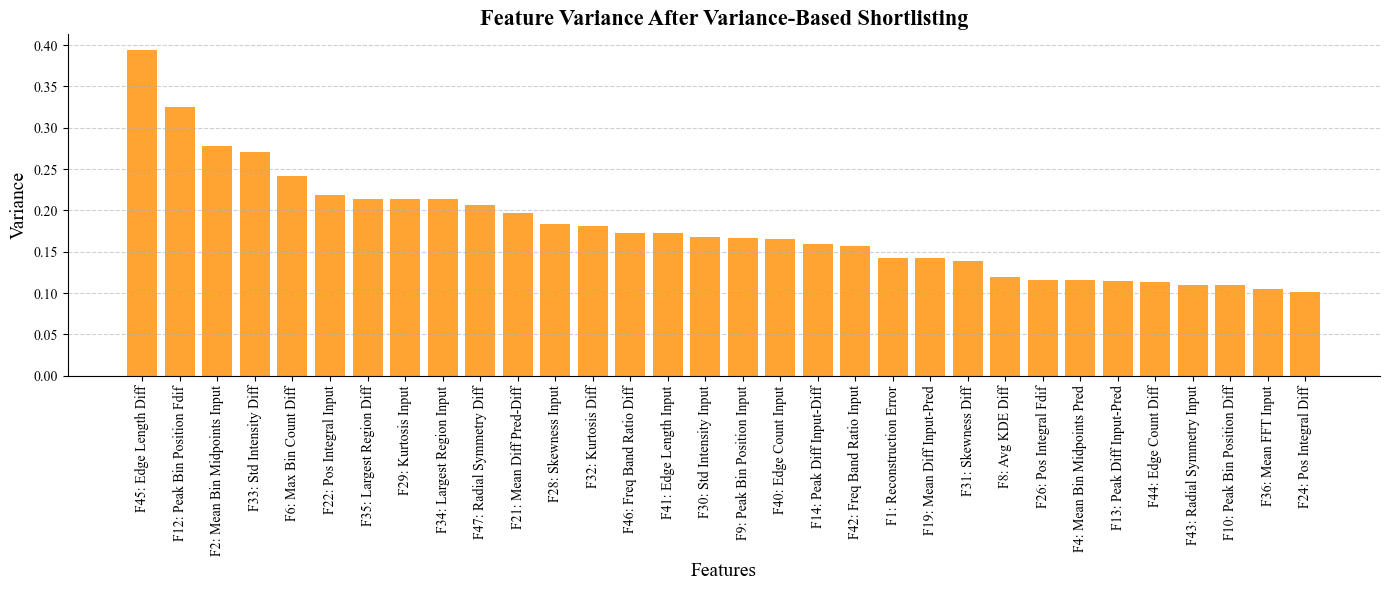

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure feature array is a NumPy array
features_variance_filtered = np.array(features_variance_filtered)

# Calculate variance for each feature **after variance-based shortlisting**
feature_variances_filtered = np.var(features_variance_filtered, axis=0)

# Create a DataFrame for plotting
df_variance_filtered = pd.DataFrame({
    "Feature Name": selected_feature_names,
    "Variance": feature_variances_filtered
})

# Sort by variance for better visualization
df_variance_filtered_sorted = df_variance_filtered.sort_values(by="Variance", ascending=False)

# Plot settings
plt.figure(figsize=(14, 6))
plt.bar(
    range(len(df_variance_filtered_sorted)), 
    df_variance_filtered_sorted["Variance"], 
    color="darkorange", alpha=0.8
)
plt.xticks(
    range(len(df_variance_filtered_sorted)), 
    df_variance_filtered_sorted["Feature Name"], 
    rotation=90, fontsize=10
)
plt.ylabel("Variance", fontsize=14)
plt.xlabel("Features", fontsize=14)
plt.title("Feature Variance After Variance-Based Shortlisting", fontsize=16, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Make the plot more visually appealing
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()


Features_variance_filtered shape: (1119, 32)
Feature headers count: 32


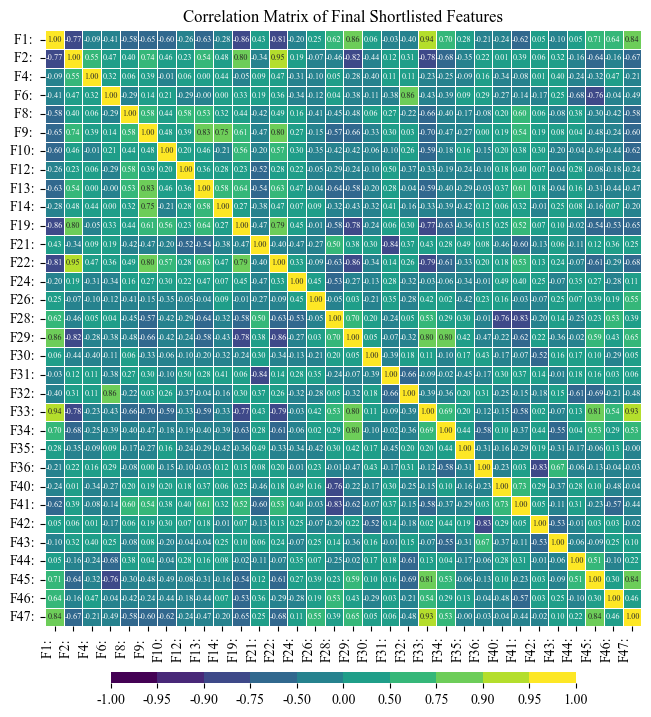

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors
import re  # Import regex for natural sorting

# Set font to Times New Roman globally
plt.rcParams["font.family"] = "Times New Roman"

# Define font sizes
title_fontsize = 12
label_fontsize = 10
tick_fontsize = 10
cbar_fontsize = 10
annot_fontsize = 6  # Font size for numbers inside boxes

# ✅ Use the first four letters of actual feature names
shortlisted_feature_headers = [name[:4] for name in selected_feature_names]

# 📌 Step 1: Define Natural Sorting Function (Sorts F2 before F12)
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', s)]

# ✅ Sort features naturally and reorder data accordingly
sorted_indices = sorted(range(len(shortlisted_feature_headers)), key=lambda i: natural_sort_key(shortlisted_feature_headers[i]))
shortlisted_feature_headers = [shortlisted_feature_headers[i] for i in sorted_indices]  # Apply sorted order
features_variance_filtered_sorted = features_variance_filtered[:, sorted_indices]  # Sort feature data

# Debugging: Ensure no mismatch
print(f"Features_variance_filtered shape: {features_variance_filtered_sorted.shape}")  # Should match headers count
print(f"Feature headers count: {len(shortlisted_feature_headers)}")  # Should match columns in features_variance_filtered_sorted

# Ensure feature headers and feature data are aligned
if features_variance_filtered_sorted.shape[1] != len(shortlisted_feature_headers):
    raise ValueError(
        f"Mismatch: features_variance_filtered_sorted has {features_variance_filtered_sorted.shape[1]} features, "
        f"but headers imply {len(shortlisted_feature_headers)}."
    )

# ✅ Create DataFrame with sorted shortlisted features
shortlisted_features_df = pd.DataFrame(features_variance_filtered_sorted, columns=shortlisted_feature_headers)

# Compute the correlation matrix after variance filtering
correlation_matrix = shortlisted_features_df.corr()

# 📌 Step 2: Use Your Custom Colormap for Sharp Color Transitions
cmap_colors = [
    "#440154", "#482878", "#3E4989", "#31688E", "#26828E",  # Strong transitions for negative correlations
    "#1F9E89", "#35B779", "#6DCD59", "#B4DE2C", "#FDE725"   # Strong transitions for positive correlations
]
cmap = mcolors.ListedColormap(cmap_colors)

# Define bins for coloring based on correlation strength
bounds = [-1.0, -0.95, -0.90, -0.75, -0.50, 0, 0.50, 0.75, 0.90, 0.95, 1.0]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# 📌 Step 3: Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 9.8))
heatmap = sns.heatmap(
    correlation_matrix,
    cmap=cmap,  # Use custom colormap
    norm=norm,  # Apply binning to enforce color ranges
    annot=True,  # Show numbers inside boxes
    fmt=".2f",  # Format numbers to 2 decimal places
    annot_kws={"size": annot_fontsize},  # Set font size for annotations
    linewidths=0.5,  # Grid lines
    square=True,  # Keep it square
    cbar=True,  # Ensure only one colorbar is added
    cbar_kws={"orientation": "horizontal", "shrink": 0.6, "pad": 0.06, "aspect": 40},  # Adjusted color bar position
    xticklabels=shortlisted_feature_headers,  # Feature names sorted naturally
    yticklabels=shortlisted_feature_headers   # Feature names sorted naturally
)

# 📌 Step 4: Ensure all range numbers appear on the color bar
cbar = heatmap.collections[0].colorbar
cbar.set_ticks(bounds)  # Set ticks to show all defined ranges
cbar.set_ticklabels([f"{b:.2f}" for b in bounds])  # Label each tick with its corresponding value
cbar.ax.tick_params(labelsize=cbar_fontsize)  # Set color bar font size

# 📌 Step 5: Improve visibility of feature names
plt.xticks(rotation=90, ha="right", fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

# 📌 Step 6: Improve visibility of labels
plt.title("Correlation Matrix of Final Shortlisted Features", fontsize=title_fontsize)

# Show the plot
plt.show()


In [87]:
best_pca_dims, best_num_clusters, best_kmeans, best_score = optimize_pca_and_kmeans(
    features_variance_filtered,  # Now using filtered features
    max_pca_dims=max_pca_dims, 
    max_clusters=max_clusters, 
    variance_threshold=variance_threshold
)

print(f"Optimal number of PCA dimensions: {best_pca_dims}")
print(f"Optimal number of clusters: {best_num_clusters}")
print(f"Best silhouette score: {best_score:.4f}")


C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

Optimal number of PCA dimensions: 9
Optimal number of clusters: 7
Best silhouette score: 0.4460


C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

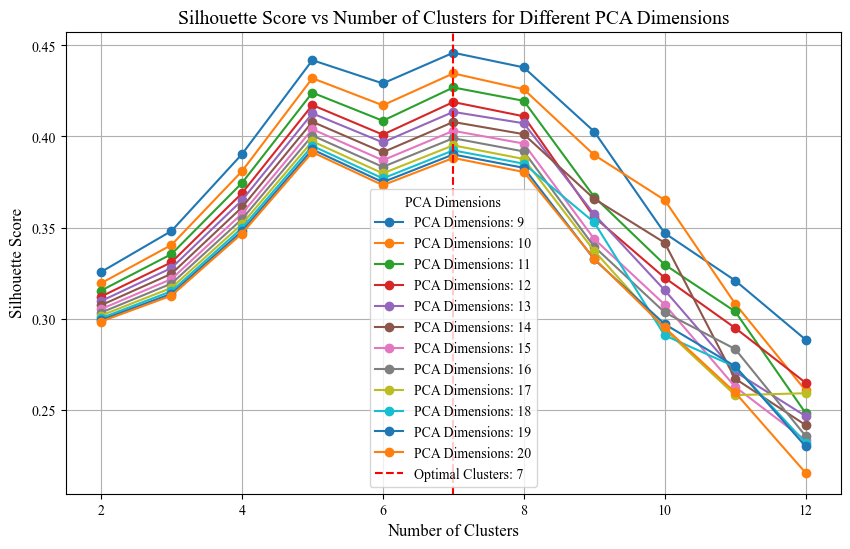

In [88]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Collect scores for plotting
cluster_range = range(2, max_clusters + 1)
pca_range = range(2, min(max_pca_dims, features_variance_filtered.shape[1]) + 1)  # Ensure PCA dims do not exceed available features
results = []

# Iterate over PCA dimensions and cluster counts to compute silhouette scores
for pca_dims in pca_range:
    pca = PCA(n_components=pca_dims)
    pca_features = pca.fit_transform(features_variance_filtered)  # Now using variance-filtered features

    explained_variance = np.sum(pca.explained_variance_ratio_)
    if explained_variance < variance_threshold:
        continue

    pca_scores = []
    for num_clusters in cluster_range:
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(pca_features)
        score = silhouette_score(pca_features, cluster_labels)
        pca_scores.append(score)

    results.append((pca_dims, pca_scores))

# Plot silhouette scores
plt.figure(figsize=(10, 6))
for pca_dims, scores in results:
    plt.plot(cluster_range, scores, marker='o', label=f'PCA Dimensions: {pca_dims}')

# Mark the optimal number of clusters
plt.axvline(x=best_num_clusters, color='r', linestyle='--', label=f'Optimal Clusters: {best_num_clusters}')

# Labels and title
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score vs Number of Clusters for Different PCA Dimensions', fontsize=14)
plt.legend(title='PCA Dimensions', fontsize=10)
plt.grid()
plt.show()


In [89]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# 📌 Step 1: Apply PCA using the best number of components found earlier
pca = PCA(n_components=best_pca_dims)
pca_features_optimized = pca.fit_transform(features_variance_filtered)  # Now using variance-filtered features
pca_columns = [f'PCA_{i+1}' for i in range(best_pca_dims)]

# 📌 Step 2: Create a DataFrame for PCA-transformed features
df_features = pd.DataFrame(pca_features_optimized, columns=pca_columns)
df_features['Cluster'] = best_kmeans.labels_
df_features['Filename'] = image_filenames  # Assuming `image_filenames` matches `features_variance_filtered` rows


# Add Image Type Information
df_features['Type'] = df_features['Filename'].apply(
    lambda x: 'Bulk' if x.startswith('Bulk') and not x.startswith('BulkDefect') 
    else 'L-C' if x.startswith('LC') 
    else 'Int' if x.startswith('interstitial') 
    else 'Vac' if x.startswith('Vacancy_CdTe')
    else 'SF-1' if x.startswith('SF1')
    else 'SF-2' if x.startswith('SF2')
    else 'TB' if x.startswith('Twin_Bound')
    #else 'Other'
    else None
)

markers = {
    'Bulk': 'o', 'L-C': 'v', 'Int': 'd', 'Vac': 's', 
    'SF-1': '*', 'SF-2': 'p', 'TB': '^'
}

colors = {
    'Bulk': 'r', 'L-C': 'g', 'Int': 'b', 'Vac': 'c', 
    'SF-1': 'brown', 'SF-2': 'm', 'TB': 'y'
}

# 📌 Step 5: Initialize accuracy tracking
cluster_accuracies = []

print("\nCluster Accuracy Details:\n")

# 📌 Step 6: Loop through each cluster to calculate accuracy and list filenames
for cluster in range(best_num_clusters):
    # Filter data for the current cluster
    cluster_df = df_features[df_features['Cluster'] == cluster]

    if len(cluster_df) == 0:
        print(f"Cluster {cluster} is empty.\n")
        cluster_accuracies.append(0)
        continue

    # Find the most frequent image type in the cluster
    most_frequent_type = cluster_df['Type'].mode()[0]
    most_frequent_type_count = cluster_df['Type'].value_counts().get(most_frequent_type, 0)

    # Calculate accuracy for the cluster
    cluster_accuracy = (most_frequent_type_count / len(cluster_df)) * 100
    cluster_accuracies.append(cluster_accuracy)

    # Print details of the cluster
    print(f"Cluster {cluster}:")
    print(f"Image Names: {', '.join(cluster_df['Filename'].values)}")
    print(f"Image Type Counts:\n{cluster_df['Type'].value_counts()}")
    print(f"Most Frequent Type: {most_frequent_type}")
    print(f"Accuracy of Cluster {cluster}: {cluster_accuracy:.2f}%\n")

# 📌 Step 7: Calculate overall accuracy
overall_accuracy = np.mean(cluster_accuracies)
print(f"✅ Overall Clustering Accuracy: {overall_accuracy:.2f}%\n")


Cluster Accuracy Details:

Cluster 0:
Image Names: LC_0.tif, LC_1.tif, LC_10.tif, LC_100.tif, LC_101.tif, LC_102.tif, LC_103.tif, LC_104.tif, LC_105.tif, LC_106.tif, LC_107.tif, LC_108.tif, LC_109.tif, LC_11.tif, LC_110.tif, LC_111.tif, LC_112.tif, LC_113.tif, LC_114.tif, LC_115.tif, LC_116.tif, LC_117.tif, LC_118.tif, LC_119.tif, LC_12.tif, LC_120.tif, LC_121.tif, LC_122.tif, LC_123.tif, LC_124.tif, LC_125.tif, LC_126.tif, LC_127.tif, LC_128.tif, LC_129.tif, LC_13.tif, LC_130.tif, LC_131.tif, LC_132.tif, LC_133.tif, LC_134.tif, LC_135.tif, LC_136.tif, LC_137.tif, LC_138.tif, LC_139.tif, LC_14.tif, LC_140.tif, LC_141.tif, LC_142.tif, LC_143.tif, LC_144.tif, LC_145.tif, LC_146.tif, LC_147.tif, LC_148.tif, LC_149.tif, LC_15.tif, LC_150.tif, LC_151.tif, LC_152.tif, LC_153.tif, LC_154.tif, LC_155.tif, LC_156.tif, LC_157.tif, LC_158.tif, LC_159.tif, LC_16.tif, LC_160.tif, LC_161.tif, LC_162.tif, LC_163.tif, LC_164.tif, LC_165.tif, LC_166.tif, LC_167.tif, LC_168.tif, LC_169.tif, LC_17.tif, 

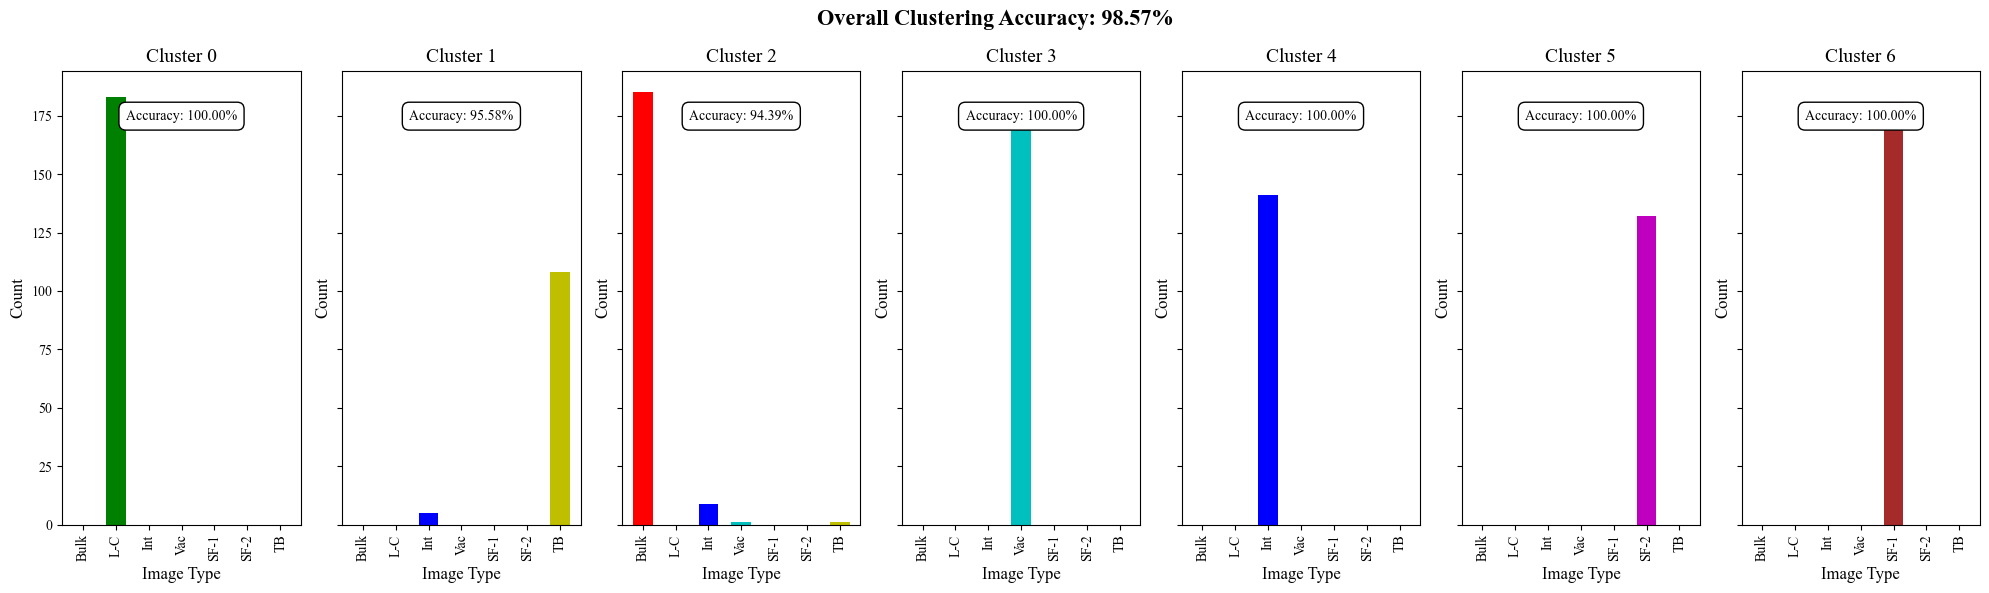

In [90]:
import matplotlib.pyplot as plt

# 📌 Step 1: Create subplots for histograms of each cluster
fig, axes = plt.subplots(1, best_num_clusters, figsize=(20, 6), sharey=True)

# 📌 Step 2: Ensure axes is always iterable (in case there's only one cluster)
if best_num_clusters == 1:
    axes = [axes]

for cluster in range(best_num_clusters):
    # 📌 Step 3: Filter data for the current cluster
    cluster_df = df_features[df_features['Cluster'] == cluster]

    # Skip empty clusters
    if len(cluster_df) == 0:
        continue

    # 📌 Step 4: Ensure all image types are present in the histogram, even if count is zero
    type_counts = cluster_df['Type'].value_counts().reindex(colors.keys(), fill_value=0)

    # 📌 Step 5: Plot the histogram for the current cluster
    ax = axes[cluster]
    bars = ax.bar(
        type_counts.index, 
        type_counts.values, 
        color=[colors[t] for t in type_counts.index if t in colors],  # Ensure only valid types
        width=0.6
    )

    # 📌 Step 6: Set title and labels for the current subplot
    ax.set_title(f"Cluster {cluster}", fontsize=14)
    ax.set_xlabel('Image Type', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x', rotation=90, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    # 📌 Step 7: Add accuracy text for the cluster
    cluster_accuracy = cluster_accuracies[cluster]
    ax.text(
        0.5, 0.9, 
        f"Accuracy: {cluster_accuracy:.2f}%", 
        ha='center', va='center', transform=ax.transAxes, fontsize=10, 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
    )

# 📌 Step 8: Add overall accuracy text as a figure title
plt.suptitle(f"Overall Clustering Accuracy: {overall_accuracy:.2f}%", fontsize=16, fontweight='bold')

# 📌 Step 9: Adjust layout and show the plot
plt.tight_layout()
plt.show()


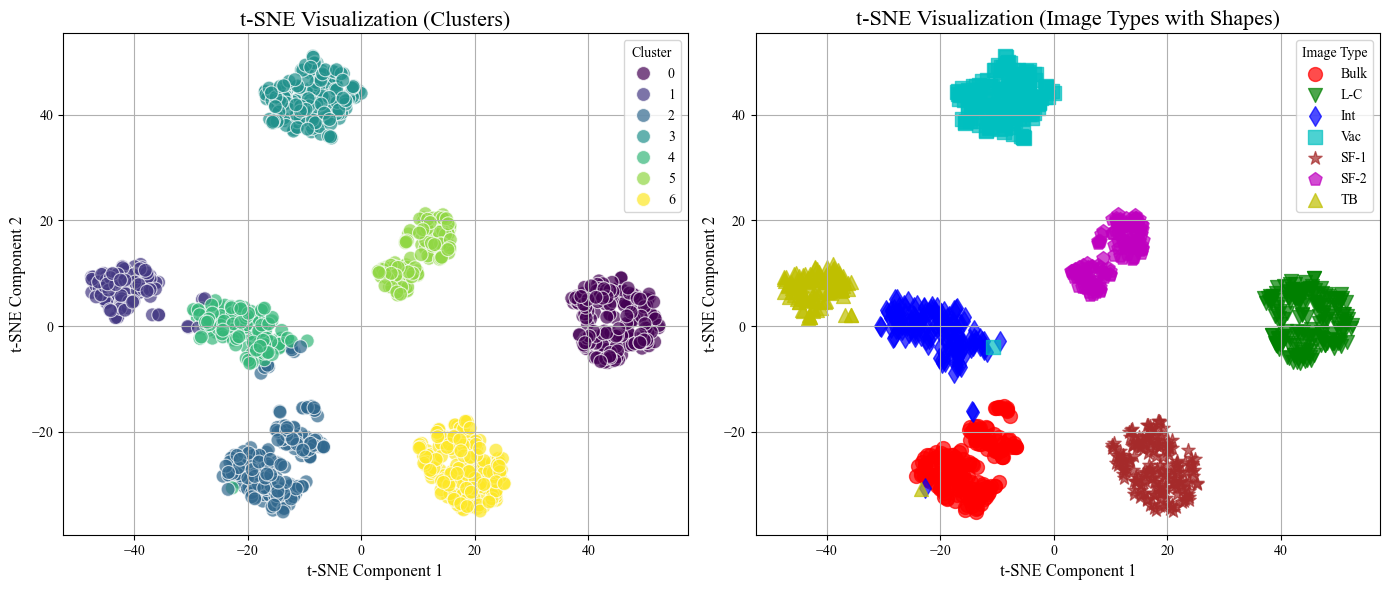

In [91]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Step 1: Apply t-SNE to reduce the optimal PCA features to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features_variance_filtered) - 1))  
tsne_features = tsne.fit_transform(pca_features_optimized)  # Now using PCA-transformed variance-filtered features

# 📌 Step 2: Add t-SNE components to the DataFrame for easier access
df_features['t-SNE1'] = tsne_features[:, 0]
df_features['t-SNE2'] = tsne_features[:, 1]

# 📌 Step 3: Create the figure for t-SNE visualization
plt.figure(figsize=(14, 6))

# 📌 Plot 1: Clusters (Color-Coded by Cluster)
plt.subplot(1, 2, 1)
sns.scatterplot(
    x='t-SNE1', 
    y='t-SNE2', 
    hue='Cluster', 
    data=df_features, 
    palette='viridis', 
    s=100,  # Point size
    alpha=0.7
)
plt.title("t-SNE Visualization (Clusters)", fontsize=16)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(title="Cluster", fontsize=10)
plt.grid()

# 📌 Plot 2: Image Types (Legends with Shapes and Colors)
plt.subplot(1, 2, 2)
for img_type in colors:  # Using colors.keys() to match defined image types
    subset = df_features[df_features['Type'] == img_type]
    plt.scatter(
        subset['t-SNE1'], 
        subset['t-SNE2'], 
        marker=markers.get(img_type, 'o'),  # Default to 'o' if type not found
        color=colors[img_type],  # Color based on image type
        label=img_type,
        alpha=0.7,
        s=100  # Point size
    )
plt.title("t-SNE Visualization (Image Types with Shapes)", fontsize=16)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(title="Image Type", fontsize=10)
plt.grid()

# 📌 Step 4: Adjust layout and show the plot
plt.tight_layout()
plt.show()
